# A molecular single-cell lung atlas of lethal COVID-19

The Dataset was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524
Download the GSE171524_RAW.tar file and save it for instance in a folder called raw. 

In [2]:
# Packages to install (if not available yet, remove ##):
## !pip install scanpy
##!pip install scvi-tools
##!pip install --upgrade pip
##!pip install scikit-misc #required for 'seurat_v3' option in scanpy
##!pip install leidenalg

In [1]:
#Import of packages
import scanpy as sc
import scvi
from scipy.sparse import csr_matrix

/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/thorsten/.pyenv/versions/3.10.6/envs/Bioinformatics/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/tho

In [16]:
# Import the read file (in this case csv file but can also be an h5 or other file formats). Use sc.read and Tab to see the possiblities for scanpy.
adata = sc.read_csv('/GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv.gz').T

In [3]:
adata # shows what adata is

AnnData object with n_obs × n_vars = 6099 × 34546

# AnnData Format
The variable adata is an Anndata format (https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html) and consist of three components:
 - adata.obs
 - adata.var 
 - adata.X
 
 adata.obs contains the cell barcodes (later additional observations are added to this dataframe)<br>
 adata.var contains the GeneNames <br>
 adata.X is the matrix with the read counts
 
 Let's get a feeling for the data. In python we can use different functions to check the dataframe/matrix and get a quick **overview** of its structure.<br>
 
 
 - .shape &rarr; shows the number of rows and columns (rows, columns) in a dataframe
 - .dtype &rarr; shows the datatype of each column (float, integer, string, object). In single cell data this works in the beginning only on the adata.X! 
 - .info &rarr; give general infos on the dataframe including column names, non-null values, and dtypes
 - .describe() &rarr; summary of numeric columns (Count, mean, std, min, 25%, 50%, 75%, max) <br>
 
 
 **Column or indices can be accessed by using:**  <br>
 - .columns &rarr; shows the column names if there is a header
 - .index &rarr; shows the indices of the dataframe <br>
 
 Below we will only show the shape but try the other commands too:)

In [4]:
adata.obs.shape

(6099, 0)

In [5]:
adata.var.shape

(34546, 0)

In [6]:
adata.X # this is a numpy array!
adata.X.shape

(6099, 34546)

# Doublet Removal 

This used scvi to remove doublets (see how to import above) and scanpy (sc) to modify the dataframes

In [7]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [8]:
Total_Number_of_genes = adata.shape[1]
Total_Number_of_genes

34546

In [9]:
# Keeps only genes that are found in at least 10 cells
sc.pp.filter_genes(adata, min_cells = 10)

In [10]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

In [11]:
Number_of_genes_filtered = adata.shape[1]
Number_of_genes_filtered

19896

In [12]:
# Small Calculation on how much percent of genes are lost
Loss_of_genes = ((Total_Number_of_genes-Number_of_genes_filtered)/Total_Number_of_genes)*100
Loss_of_genes

42.407225149076595

In [13]:
# Subset the top 2000 genes of the dataset to train the scvi model (to be quicker and it is sufficient training material)
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [14]:
# Check if subsetting worked
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [15]:
# Train the SCVI Model
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [16]:
# Train the doublet class model (it has an stop inside if loss is not changing anymore)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.288. Signaling Trainer to stop.


In [17]:
# Use predict to annotate the cell barcodes with the trained identifier and annotate it as a string in "doublet" or "singlet"
df = solo.predict()
df['prediction'] = solo.predict(soft=False)
df

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


doublet   singlet prediction
TAGGTACCATGGCCAC-1_1  0.806161  0.193839    doublet
ATTCACTGTAACAGGC-1_1  0.896878  0.103122    doublet
TAACTTCCAACCACGC-1_1  0.639890  0.360110    doublet
TTGGGTACACGACAAG-1_1  0.728426  0.271574    doublet
AGGCCACAGAGTCACG-1_1  0.791725  0.208275    doublet
...                        ...       ...        ...
CGCCATTGTTTGCCGG-1_1  0.033506  0.966494    singlet
CACTGGGGTCTACGTA-1_1  0.001865  0.998135    singlet
CATACTTGTAGAGGAA-1_1  0.007503  0.992497    singlet
TTTGGTTTCCACGGAC-1_1  0.002731  0.997269    singlet
ATGCATGAGTCATGAA-1_1  0.005801  0.994199    singlet

[6099 rows x 3 columns]

In [18]:
# Check how much cells are lost (close to 20%)
df.groupby('prediction').count()

doublet  singlet
prediction                  
doublet        1122     1122
singlet        4977     4977

In [39]:
#Calculating the difference of doublet and singlet score to identify cells that have high scores in both (close to 0)
df['dif'] = df.doublet - df.singlet
df

doublet   singlet prediction       dif
TAGGTACCATGGCCAC-1_1  0.806161  0.193839    doublet  0.612323
ATTCACTGTAACAGGC-1_1  0.896878  0.103122    doublet  0.793757
TAACTTCCAACCACGC-1_1  0.639890  0.360110    doublet  0.279781
TTGGGTACACGACAAG-1_1  0.728426  0.271574    doublet  0.456851
AGGCCACAGAGTCACG-1_1  0.791725  0.208275    doublet  0.583451
...                        ...       ...        ...       ...
CGCCATTGTTTGCCGG-1_1  0.033506  0.966494    singlet -0.932988
CACTGGGGTCTACGTA-1_1  0.001865  0.998135    singlet -0.996270
CATACTTGTAGAGGAA-1_1  0.007503  0.992497    singlet -0.984994
TTTGGTTTCCACGGAC-1_1  0.002731  0.997269    singlet -0.994538
ATGCATGAGTCATGAA-1_1  0.005801  0.994199    singlet -0.988398

[6099 rows x 4 columns]

In [20]:
import seaborn as sns

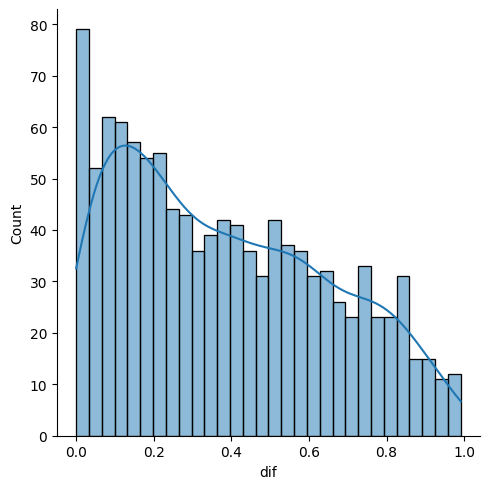

In [24]:
#Use seaborn to show histogram of dif and decide emperically a cutoff
sns.displot(df[df.prediction == 'doublet'], x= 'dif', bins=30, kde=True)

In [50]:
# Generate a list containing only filtered doublet cells (to not loose to much data)
doublets = df[(df['prediction'] == 'doublet') & (df.dif > 0.42)]
doublets

doublet   singlet prediction       dif
TAGGTACCATGGCCAC-1_1  0.806161  0.193839    doublet  0.612323
ATTCACTGTAACAGGC-1_1  0.896878  0.103122    doublet  0.793757
TTGGGTACACGACAAG-1_1  0.728426  0.271574    doublet  0.456851
AGGCCACAGAGTCACG-1_1  0.791725  0.208275    doublet  0.583451
CACTGAAGTCGAAGCA-1_1  0.731615  0.268385    doublet  0.463231
...                        ...       ...        ...       ...
CAATACGCAATGTGGG-1_1  0.716351  0.283649    doublet  0.432701
AAAGAACGTACACTCA-1_1  0.935838  0.064162    doublet  0.871677
GGGCTACTCGTGCAGC-1_1  0.729028  0.270972    doublet  0.458057
ATCAGGTGTCGTCTCT-1_1  0.840900  0.159100    doublet  0.681800
GGCTTTCTCTACACAG-1_1  0.779454  0.220546    doublet  0.558908

[465 rows x 4 columns]

In [51]:
# Reload adata and annotate doublet annotation on all barcodes/cells (before we filtered out already many cells to train the model!)
adata = sc.read_csv('/GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv.gz').T
# This annotates the cells with True/false True = doublet, false = singlet
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

doublet
TAGGTACCATGGCCAC-1_1     True
ATTCACTGTAACAGGC-1_1     True
TAACTTCCAACCACGC-1_1    False
TTGGGTACACGACAAG-1_1     True
AGGCCACAGAGTCACG-1_1     True
...                       ...
CGCCATTGTTTGCCGG-1_1    False
CACTGGGGTCTACGTA-1_1    False
CATACTTGTAGAGGAA-1_1    False
TTTGGTTTCCACGGAC-1_1    False
ATGCATGAGTCATGAA-1_1    False

[6099 rows x 1 columns]

In [52]:
# Filter adata for singlets (~ means you keep the false which are the singlets)
adata = adata[~adata.obs.doublet]
# Check how many cells are left over
adata

View of AnnData object with n_obs × n_vars = 5634 × 34546
    obs: 'doublet'

# Preprocessing

In [53]:
#Filter adata.var for removal of MT genes 
adata.var['mt'] = adata.var[adata.var.index.str.startswith('MT-')]

Empty DataFrameView
Columns: []
Index: [AL627309.1, AL627309.5, AL627309.4, AL669831.2, LINC01409, FAM87B, LINC01128, LINC00115, FAM41C, AL645608.6, AL645608.2, LINC02593, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, AL645608.7, HES4, ISG15, AL645608.1, AGRN, C1orf159, AL390719.3, LINC01342, AL390719.2, TTLL10-AS1, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, UBE2J2, LINC01786, SCNN1D, ACAP3, PUSL1, INTS11, AL139287.1, CPTP, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20-AS1, MRPL20, AL391244.2, ANKRD65, AL391244.1, LINC01770, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, AL645728.1, FNDC10, AL691432.4, AL691432.2, MIB2, MMP23B, CDK11B, FO704657.1, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, AL109917.1, CALML6, TMEM52, CFAP74, GABRD, AL391845.1, PRKCZ, AL590822.2, PRKCZ-AS1, FAAP20, AL590822.1, SKI, AL590822.3, MORN1, AL589739.1, AL513477.2, RER1, PEX10, PLCH2, AL139246.4, PANK4, HES5, AL139246.5, TNFRSF14-AS1, TNFRSF14, AL139246.3, PRXL2B, MMEL1, TTC34, AC242022.2, ...]

[34546 rows x 0 columns]

In [64]:
#Using boolean series to assign if mitochondrial gene or not to adata.var dataframe
adata.var['mt'] = adata.var.index.str.startswith('MT-')

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_45124/310233584.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [65]:
adata.var

mt
AL627309.1  False
AL627309.5  False
AL627309.4  False
AL669831.2  False
LINC01409   False
...           ...
VN1R2       False
AL031676.1  False
SMIM34A     False
AL050402.1  False
AL445072.1  False

[34546 rows x 1 columns]

Next we annotated the ribosomal genes. 

In [23]:
import pandas as pd

In [24]:

ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"


In [25]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_genes

0
0          FAU
1       MRPL13
2        RPL10
3       RPL10A
4       RPL10L
..         ...
83        RPS9
84        RPSA
85     RSL24D1
86  RSL24D1P11
87       UBA52

[88 rows x 1 columns]

In [77]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [78]:
adata.var

mt   ribo
AL627309.1  False  False
AL627309.5  False  False
AL627309.4  False  False
AL669831.2  False  False
LINC01409   False  False
...           ...    ...
VN1R2       False  False
AL031676.1  False  False
SMIM34A     False  False
AL050402.1  False  False
AL445072.1  False  False

[34546 rows x 2 columns]

In [79]:
# Calculate statistic for ribosomal, mitochondrial, UMI number and genes per cell (in adata.var and adata.obs)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

In [80]:
adata.var

mt   ribo  n_cells_by_counts  mean_counts  \
AL627309.1  False  False                  6     0.001065   
AL627309.5  False  False                 26     0.004615   
AL627309.4  False  False                  3     0.000532   
AL669831.2  False  False                  2     0.000355   
LINC01409   False  False                231     0.044373   
...           ...    ...                ...          ...   
VN1R2       False  False                  0     0.000000   
AL031676.1  False  False                  0     0.000000   
SMIM34A     False  False                  0     0.000000   
AL050402.1  False  False                  0     0.000000   
AL445072.1  False  False                  0     0.000000   

            pct_dropout_by_counts  total_counts  
AL627309.1              99.893504           6.0  
AL627309.5              99.538516          26.0  
AL627309.4              99.946752           3.0  
AL669831.2              99.964501           2.0  
LINC01409               95.899894         250.0  
...                           ...           ...  
VN1R2                  100.000000           0.0  
AL031676.1             100.000000           0.0  
SMIM34A                100.000000           0.0  
AL050402.1             100.000000           0.0  
AL445072.1             100.000000           0.0  

[34546 rows x 6 columns]

In [81]:
adata.obs

doublet  n_genes_by_counts  total_counts  \
TAACTTCCAACCACGC-1_1    False               5158       15645.0   
TTGGTTTTCCTAGCTC-1_1    False               3902       11472.0   
CGCATAACATGCCGGT-1_1    False               3745        8617.0   
TCTATCACAAGGCTTT-1_1    False               3582        8276.0   
CACTTCGCAGTACTAC-1_1    False               3244        8059.0   
...                       ...                ...           ...   
CGCCATTGTTTGCCGG-1_1    False                355         410.0   
CACTGGGGTCTACGTA-1_1    False                346         403.0   
CATACTTGTAGAGGAA-1_1    False                360         410.0   
TTTGGTTTCCACGGAC-1_1    False                299         405.0   
ATGCATGAGTCATGAA-1_1    False                351         411.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
TAACTTCCAACCACGC-1_1            221.0       1.412592              211.0   
TTGGTTTTCCTAGCTC-1_1            463.0       4.035913               13.0   
CGCATAACATGCCGGT-1_1            119.0       1.380991               25.0   
TCTATCACAAGGCTTT-1_1            183.0       2.211213                5.0   
CACTTCGCAGTACTAC-1_1            253.0       3.139347               14.0   
...                               ...            ...                ...   
CGCCATTGTTTGCCGG-1_1              3.0       0.731707                0.0   
CACTGGGGTCTACGTA-1_1              0.0       0.000000                0.0   
CATACTTGTAGAGGAA-1_1              2.0       0.487805                0.0   
TTTGGTTTCCACGGAC-1_1              0.0       0.000000                2.0   
ATGCATGAGTCATGAA-1_1              0.0       0.000000                0.0   

                      pct_counts_ribo  
TAACTTCCAACCACGC-1_1         1.348674  
TTGGTTTTCCTAGCTC-1_1         0.113319  
CGCATAACATGCCGGT-1_1         0.290124  
TCTATCACAAGGCTTT-1_1         0.060416  
CACTTCGCAGTACTAC-1_1         0.173719  
...                               ...  
CGCCATTGTTTGCCGG-1_1         0.000000  
CACTGGGGTCTACGTA-1_1         0.000000  
CATACTTGTAGAGGAA-1_1         0.000000  
TTTGGTTTCCACGGAC-1_1         0.493827  
ATGCATGAGTCATGAA-1_1         0.000000  

[5634 rows x 7 columns]

In [82]:
# Before filtering table includes genes not occuring in cells
adata.var.sort_values('n_cells_by_counts')

mt   ribo  n_cells_by_counts  mean_counts  \
AL445072.1  False  False                  0     0.000000   
AC092958.4  False  False                  0     0.000000   
AC092994.1  False  False                  0     0.000000   
C3orf80     False  False                  0     0.000000   
AC026316.2  False  False                  0     0.000000   
...           ...    ...                ...          ...   
AKAP13      False  False               4034     2.814696   
MBNL1       False  False               4126     2.668974   
NEAT1       False  False               4135     4.908591   
ZBTB20      False  False               4270     2.399006   
MALAT1      False  False               5625    63.596557   

            pct_dropout_by_counts  total_counts  
AL445072.1             100.000000           0.0  
AC092958.4             100.000000           0.0  
AC092994.1             100.000000           0.0  
C3orf80                100.000000           0.0  
AC026316.2             100.000000           0.0  
...                           ...           ...  
AKAP13                  28.399006       15858.0  
MBNL1                   26.766063       15037.0  
NEAT1                   26.606319       27655.0  
ZBTB20                  24.210153       13516.0  
MALAT1                   0.159744      358303.0  

[34546 rows x 6 columns]

In [83]:
#Filtering genes to be detected at least in 3 cells
sc.pp.filter_genes(adata, min_cells=3)

In [84]:
# after filtering each gene occurs at least in 3 cells
adata.var.sort_values('n_cells_by_counts')

mt   ribo  n_cells_by_counts  mean_counts  \
LINC02478   False  False                  3     0.000532   
AL358333.1  False  False                  3     0.000532   
AL139317.3  False  False                  3     0.000532   
SH3TC2-DT   False  False                  3     0.000532   
TBPL2       False  False                  3     0.000532   
...           ...    ...                ...          ...   
AKAP13      False  False               4034     2.814696   
MBNL1       False  False               4126     2.668974   
NEAT1       False  False               4135     4.908591   
ZBTB20      False  False               4270     2.399006   
MALAT1      False  False               5625    63.596557   

            pct_dropout_by_counts  total_counts  n_cells  
LINC02478               99.946752           3.0        3  
AL358333.1              99.946752           3.0        3  
AL139317.3              99.946752           3.0        3  
SH3TC2-DT               99.946752           3.0        3  
TBPL2                   99.946752           3.0        3  
...                           ...           ...      ...  
AKAP13                  28.399006       15858.0     4034  
MBNL1                   26.766063       15037.0     4126  
NEAT1                   26.606319       27655.0     4135  
ZBTB20                  24.210153       13516.0     4270  
MALAT1                   0.159744      358303.0     5625  

[24121 rows x 7 columns]

In [87]:

adata.obs.sort_values('total_counts')

doublet  n_genes_by_counts  total_counts  \
TGGTACAGTTGGTGTT-1_1    False                323         401.0   
CGAGAAGGTGAACTAA-1_1    False                308         401.0   
CAGGGCTTCATGCGGC-1_1    False                330         401.0   
AGGCATTCATCCGTTC-1_1    False                290         401.0   
GTCGTTCTCCAAGGGA-1_1    False                300         401.0   
...                       ...                ...           ...   
CACTTCGCAGTACTAC-1_1    False               3244        8059.0   
TCTATCACAAGGCTTT-1_1    False               3582        8276.0   
CGCATAACATGCCGGT-1_1    False               3745        8617.0   
TTGGTTTTCCTAGCTC-1_1    False               3902       11472.0   
TAACTTCCAACCACGC-1_1    False               5158       15645.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
TGGTACAGTTGGTGTT-1_1              0.0       0.000000                0.0   
CGAGAAGGTGAACTAA-1_1              0.0       0.000000                0.0   
CAGGGCTTCATGCGGC-1_1              7.0       1.745636                1.0   
AGGCATTCATCCGTTC-1_1              1.0       0.249377                0.0   
GTCGTTCTCCAAGGGA-1_1              0.0       0.000000                0.0   
...                               ...            ...                ...   
CACTTCGCAGTACTAC-1_1            253.0       3.139347               14.0   
TCTATCACAAGGCTTT-1_1            183.0       2.211213                5.0   
CGCATAACATGCCGGT-1_1            119.0       1.380991               25.0   
TTGGTTTTCCTAGCTC-1_1            463.0       4.035913               13.0   
TAACTTCCAACCACGC-1_1            221.0       1.412592              211.0   

                      pct_counts_ribo  n_genes  
TGGTACAGTTGGTGTT-1_1         0.000000      323  
CGAGAAGGTGAACTAA-1_1         0.000000      307  
CAGGGCTTCATGCGGC-1_1         0.249377      330  
AGGCATTCATCCGTTC-1_1         0.000000      290  
GTCGTTCTCCAAGGGA-1_1         0.000000      299  
...                               ...      ...  
CACTTCGCAGTACTAC-1_1         0.173719     3242  
TCTATCACAAGGCTTT-1_1         0.060416     3575  
CGCATAACATGCCGGT-1_1         0.290124     3729  
TTGGTTTTCCTAGCTC-1_1         0.113319     3897  
TAACTTCCAACCACGC-1_1         1.348674     5143  

[5634 rows x 8 columns]

The authors of this paper have already filtered the cells for a minimum count of 400 but if they would have not we would filter the cells to have a minimum number of read counts like following: 

In [86]:
# sc.pp.filter_cells(adata, min_genes=200) # the 200 is arbitrary based on data

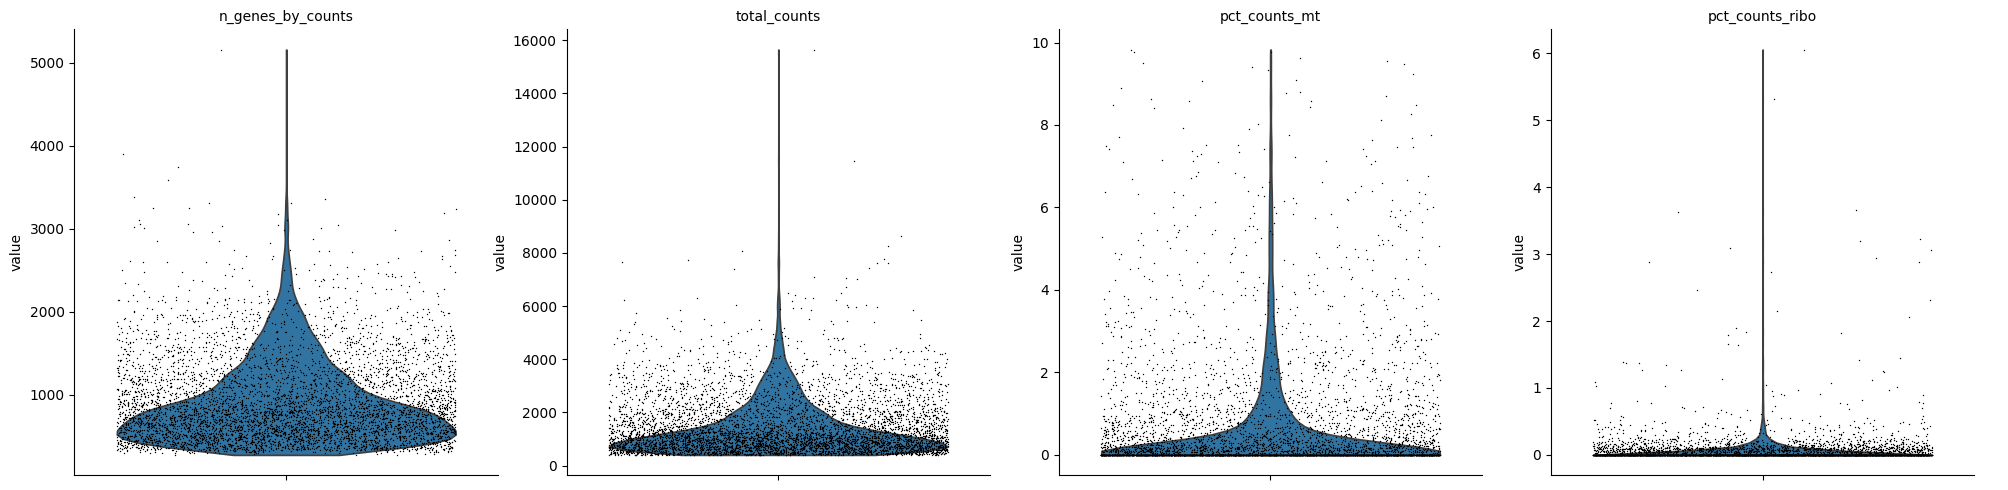

In [88]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter = 0.4, multi_panel = True)

We use these QC metrics to remove outliers. For instance if a cell still has more genes_by_counts or total_counts (these two are highly correlated) than the average cell population this strongly indicates an artifact. Since those two are corrleated we filter by one metric only. Furthermore we will also exclude cells with too high mitochondrial percentage which indicates sequencing artifacts or that the cell is dying. Typically people filters between 5-20% of MT out. Ribosomal reads are also a quality control. High percentage of ribosomal reads indicates low-quality cells (mRNA degradation and therefore rRNA dominates), low RNA complexity (cell contains mainly houskeeping transcripts) and if ambient RNA is present (due to lysed cells) rRNA can make up larger proportions. 

In [26]:
import numpy as np

In [90]:
# Determines the 98th percentile using Numpy to be more objective and not only set a limit by watching the graph.
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)

In [91]:
upper_lim

2256.0

In [92]:
# Fitler adata to contain only cells having less genes than the upper limit
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [94]:
adata.obs

doublet  n_genes_by_counts  total_counts  \
ATACTTCCAAGGTCTT-1_1    False               2122        5252.0   
TCATGCCGTCTTTCAT-1_1    False               2234        4993.0   
GATAGCTCAGGCTTGC-1_1    False               2167        4879.0   
TACATTCGTACGTACT-1_1    False               2253        4776.0   
GACCCAGCACCCTATC-1_1    False               2150        4784.0   
...                       ...                ...           ...   
CGCCATTGTTTGCCGG-1_1    False                355         410.0   
CACTGGGGTCTACGTA-1_1    False                346         403.0   
CATACTTGTAGAGGAA-1_1    False                360         410.0   
TTTGGTTTCCACGGAC-1_1    False                299         405.0   
ATGCATGAGTCATGAA-1_1    False                351         411.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
ATACTTCCAAGGTCTT-1_1              1.0       0.019040                4.0   
TCATGCCGTCTTTCAT-1_1              0.0       0.000000                3.0   
GATAGCTCAGGCTTGC-1_1              0.0       0.000000                0.0   
TACATTCGTACGTACT-1_1             13.0       0.272194                1.0   
GACCCAGCACCCTATC-1_1             28.0       0.585284                4.0   
...                               ...            ...                ...   
CGCCATTGTTTGCCGG-1_1              3.0       0.731707                0.0   
CACTGGGGTCTACGTA-1_1              0.0       0.000000                0.0   
CATACTTGTAGAGGAA-1_1              2.0       0.487805                0.0   
TTTGGTTTCCACGGAC-1_1              0.0       0.000000                2.0   
ATGCATGAGTCATGAA-1_1              0.0       0.000000                0.0   

                      pct_counts_ribo  n_genes  
ATACTTCCAAGGTCTT-1_1         0.076161     2120  
TCATGCCGTCTTTCAT-1_1         0.060084     2229  
GATAGCTCAGGCTTGC-1_1         0.000000     2166  
TACATTCGTACGTACT-1_1         0.020938     2250  
GACCCAGCACCCTATC-1_1         0.083612     2149  
...                               ...      ...  
CGCCATTGTTTGCCGG-1_1         0.000000      355  
CACTGGGGTCTACGTA-1_1         0.000000      346  
CATACTTGTAGAGGAA-1_1         0.000000      360  
TTTGGTTTCCACGGAC-1_1         0.493827      299  
ATGCATGAGTCATGAA-1_1         0.000000      350  

[5520 rows x 8 columns]

In [96]:
# Next filter the mitochondria on 20% 
adata = adata[adata.obs.pct_counts_mt < 20]

In [97]:
# Filter on ribosomal percentage 
adata = adata[adata.obs.pct_counts_ribo < 2]

In [98]:
adata

View of AnnData object with n_obs × n_vars = 5504 × 24121
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# Normalization

In adata X each row is a cell and each column is a gene

In [100]:
# Showing that each cell has a different number of total counts
adata.X.sum(axis=1)

array([5250., 4988., 4878., ...,  410.,  405.,  410.], dtype=float32)

Normalization includes to normalize the counts of each cell so that the total counts adds up to the same value.

In [102]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize to 10000 UMIs

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [103]:
# After normalization the total counts of each cell is the same!
adata.X.sum(axis=1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [104]:
# Change to log counts
sc.pp.log1p(adata)

In [105]:
adata.X.sum(axis=1)

array([2858.1602, 3191.3232, 3131.851 , ..., 1191.2706, 1022.7512,
       1162.8784], dtype=float32)

**!!! Important !!!*** Now it is very important to freeze the data as it is now. Before we do further start filtering out genes, regressing data or scale data. 
For this we safe it in the raw slot of the adata format. 

In [106]:
adata.raw = adata
#Lot of functions later will actually use the raw data!

# Clustering

In [107]:
#Adds statistic about variability of gene expression into adata.var
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [109]:
adata.var

mt   ribo  n_cells_by_counts  mean_counts  \
AL627309.1  False  False                  6     0.001065   
AL627309.5  False  False                 26     0.004615   
AL627309.4  False  False                  3     0.000532   
LINC01409   False  False                231     0.044373   
FAM87B      False  False                  6     0.001065   
...           ...    ...                ...          ...   
AL354822.1  False  False                116     0.020944   
AL592183.1  False  False                858     0.179801   
AC240274.1  False  False                139     0.025204   
AC007325.4  False  False                  4     0.000710   
AC007325.2  False  False                  5     0.000887   

            pct_dropout_by_counts  total_counts  n_cells  highly_variable  \
AL627309.1              99.893504           6.0        6             True   
AL627309.5              99.538516          26.0       26            False   
AL627309.4              99.946752           3.0        3            False   
LINC01409               95.899894         250.0      231            False   
FAM87B                  99.893504           6.0        6            False   
...                           ...           ...      ...              ...   
AL354822.1              97.941072         118.0      116            False   
AL592183.1              84.771033        1013.0      858            False   
AC240274.1              97.532836         142.0      139            False   
AC007325.4              99.929002           4.0        4            False   
AC007325.2              99.911253           5.0        5            False   

               means  dispersions  dispersions_norm  
AL627309.1  0.010376     2.815590          1.415001  
AL627309.5  0.029318     2.300095         -0.164139  
AL627309.4  0.002524     1.702826         -1.993777  
LINC01409   0.265627     2.331154         -0.068994  
FAM87B      0.007235     1.947622         -1.243883  
...              ...          ...               ...  
AL354822.1  0.154065     2.424779          0.217811  
AL592183.1  0.872996     2.513105         -0.404280  
AC240274.1  0.150549     2.312172         -0.127142  
AC007325.4  0.003033     1.579870         -2.370433  
AC007325.2  0.005456     2.044975         -0.945656  

[24121 rows x 11 columns]

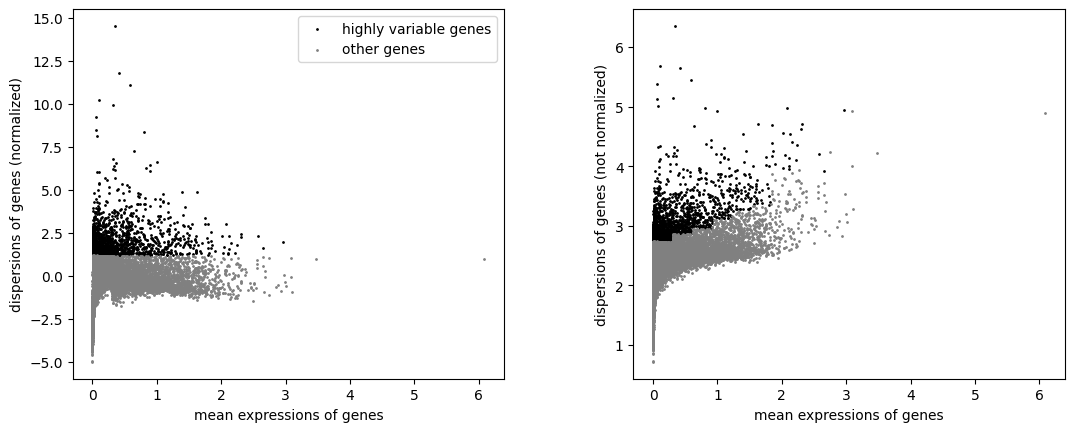

In [110]:
sc.pl.highly_variable_genes(adata)

In [111]:
# Filter to only keep the highly variable genes, non of this touches the raw data we saved earlier
adata = adata[:,adata.var.highly_variable]

In [113]:
# We regress out differences that arise due to total counts, pct_counts_mt, pct_counts_ribo. 
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:729: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [114]:
sc.pp.scale(adata, max_value=10)

In [117]:
sc.tl.pca(adata, svd_solver='arpack')

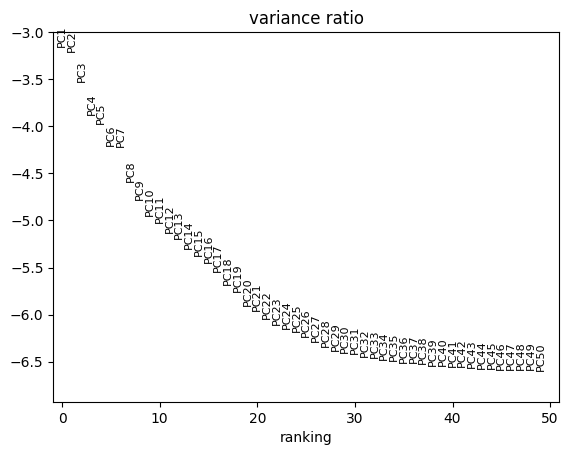

In [119]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)
# Find the ellbow

In [120]:
# Calculate the neighbors of the cells using the Top30 PCAs.
sc.pp.neighbors(adata, n_pcs = 30)

How to look into the "neighbors" (cell by cell matrix, if they are connected they have a value in connectivities, 
and each of the connected cells will also have a distance. Below how to see the matrix (remove # to run it)

In [125]:
# adata.obsp['connectivities'].toarray()
# adata.obsp['distances'].toarray()

array([[0.        , 3.98042417, 4.91456842, ..., 0.        , 0.        ,
        0.        ],
       [3.98042417, 0.        , 3.33684683, ..., 0.        , 0.        ,
        0.        ],
       [4.91456842, 3.33684683, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

This neighborhood matrices are used for clustering. 

In [159]:
sc.tl.umap(adata)

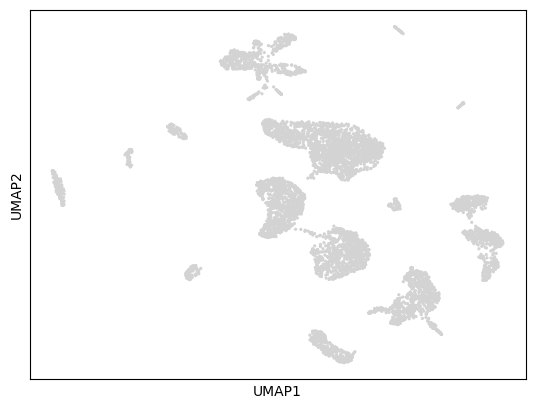

In [160]:
sc.pl.umap(adata)

In [165]:
sc.tl.leiden(adata, resolution=0.3, key_added='leiden_fc', flavor="igraph", n_iterations=1)

In [166]:
adata.obs

doublet  n_genes_by_counts  total_counts  \
ATACTTCCAAGGTCTT-1_1    False               2122        5252.0   
TCATGCCGTCTTTCAT-1_1    False               2234        4993.0   
GATAGCTCAGGCTTGC-1_1    False               2167        4879.0   
TACATTCGTACGTACT-1_1    False               2253        4776.0   
GACCCAGCACCCTATC-1_1    False               2150        4784.0   
...                       ...                ...           ...   
CGCCATTGTTTGCCGG-1_1    False                355         410.0   
CACTGGGGTCTACGTA-1_1    False                346         403.0   
CATACTTGTAGAGGAA-1_1    False                360         410.0   
TTTGGTTTCCACGGAC-1_1    False                299         405.0   
ATGCATGAGTCATGAA-1_1    False                351         411.0   

                      total_counts_mt  pct_counts_mt  total_counts_ribo  \
ATACTTCCAAGGTCTT-1_1              1.0       0.019040                4.0   
TCATGCCGTCTTTCAT-1_1              0.0       0.000000                3.0   
GATAGCTCAGGCTTGC-1_1              0.0       0.000000                0.0   
TACATTCGTACGTACT-1_1             13.0       0.272194                1.0   
GACCCAGCACCCTATC-1_1             28.0       0.585284                4.0   
...                               ...            ...                ...   
CGCCATTGTTTGCCGG-1_1              3.0       0.731707                0.0   
CACTGGGGTCTACGTA-1_1              0.0       0.000000                0.0   
CATACTTGTAGAGGAA-1_1              2.0       0.487805                0.0   
TTTGGTTTCCACGGAC-1_1              0.0       0.000000                2.0   
ATGCATGAGTCATGAA-1_1              0.0       0.000000                0.0   

                      pct_counts_ribo  n_genes leiden leiden_fc  
ATACTTCCAAGGTCTT-1_1         0.076161     2120      0         0  
TCATGCCGTCTTTCAT-1_1         0.060084     2229      0         0  
GATAGCTCAGGCTTGC-1_1         0.000000     2166      0         0  
TACATTCGTACGTACT-1_1         0.020938     2250      1         1  
GACCCAGCACCCTATC-1_1         0.083612     2149      0         0  
...                               ...      ...    ...       ...  
CGCCATTGTTTGCCGG-1_1         0.000000      355      1         1  
CACTGGGGTCTACGTA-1_1         0.000000      346      2         2  
CATACTTGTAGAGGAA-1_1         0.000000      360     12        12  
TTTGGTTTCCACGGAC-1_1         0.493827      299      7         7  
ATGCATGAGTCATGAA-1_1         0.000000      350      2         2  

[5504 rows x 10 columns]

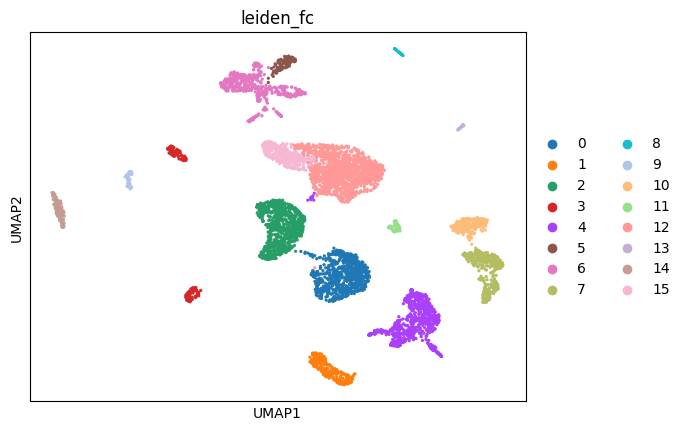

In [167]:
sc.pl.umap(adata, color=['leiden_fc'])

# Integration of multiple samples (above  was only one!)

In [27]:
# Function for preprocessing of each sample
def preprocessing(csv_path):
    adata = sc.read_csv(csv_path).T
    # Fitler genes to be expressed at least in 10 cells
    sc.pp.filter_genes(adata, min_cells = 10)
    #Subsetting for doublet removal the 2000 top-variable genes)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    #SCVI model for doublet removal
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    #df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 0.42)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]
    adata.X = csr_matrix(adata.X)

    return adata

In [28]:
import os

In [29]:
out = []
for f in [file for file in os.listdir('./') if file.endswith ('.csv.gz')]:    
    out.append(preprocessing('./' + f))


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.199. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.287. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.261. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.312. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.317. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.194. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.363. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.237. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.274. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.279. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.311. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.344. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.299. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.289. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.320. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.286. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.182. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.212. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.248. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.293. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.328. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.341. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.305. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.270. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.313. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.246. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.262. Signaling Trainer to stop.


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying

⚠️ Memory Warning (SCVI Training)

    Note: Training SCVI models, especially during data concatenation or preprocessing, can be very memory-intensive. On a typical laptop setup (e.g., MacBook), this step often causes the Jupyter kernel to crash due to insufficient RAM. Running this pipeline on a machine with larger memory resources (e.g., a workstation or cloud VM) is highly recommended.

To avoid the hassle of reinstalling dependencies or configuring Python environments on another machine, this repository includes a **Docker setup**. Simply use the provided Dockerfile to replicate the environment on any compatible system. How to run the docker: 

1.) Move the files (Dockerfile, requirements.txt, SCVI_Model_Training_Concatenation.py) in the Docker directory,   into the folder where youre have your directory named **raw_counts** which contain the raw counts of the single cell dataset. <br>
2.) Change the directory in your terminal to the same location. <br>
3.) Build the Docker by running: **docker build -t scvimodel .** <br>
4.) When the image was build run the Docker with: run --rm -v $(pwd):/app scvimodel 

**Note:** that the SCVI_Model_Training_Concatenation.py script is adapted to this dataset (mt, ribo cutoffs, nameing of files etc). If you use it for a different dataset make sure to change the parameters to your setting!


In [ ]:
# adata = sc.concat(out)

In [10]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

In [11]:
adata = sc.read_h5ad('TK_SCA_combined.h5ad')
adata

AnnData object with n_obs × n_vars = 108822 × 29581
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [12]:
adata.X

<108822x29581 sparse matrix of type '<class 'numpy.float32'>'
	with 95760461 stored elements in Compressed Sparse Row format>

In [13]:
#Check how many cells per sample by groupby count
adata.obs.groupby('Sample').count()

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_19588/68267705.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


doublet  n_genes  n_genes_by_counts  total_counts  \
Sample                                                           
C51ctr          5960     5960               5960          5960   
C52ctr          4415     4415               4415          4415   
C53ctr          6928     6928               6928          6928   
C54ctr          4284     4284               4284          4284   
C55ctr          5565     5565               5565          5565   
C56ctr          3904     3904               3904          3904   
C57ctr          4687     4687               4687          4687   
L01cov          2952     2952               2952          2952   
L03cov          3953     3953               3953          3953   
L04cov          3401     3401               3401          3401   
L04covaddon     4386     4386               4386          4386   
L05cov          2696     2696               2696          2696   
L06cov          6306     6306               6306          6306   
L07cov          4753     4753               4753          4753   
L08cov          3767     3767               3767          3767   
L09cov          3368     3368               3368          3368   
L10cov          1501     1501               1501          1501   
L11cov          2888     2888               2888          2888   
L12cov          3648     3648               3648          3648   
L13cov          4732     4732               4732          4732   
L15cov          3905     3905               3905          3905   
L16cov          1773     1773               1773          1773   
L17cov          4341     4341               4341          4341   
L18cov          2633     2633               2633          2633   
L19cov          2429     2429               2429          2429   
L21cov          3257     3257               3257          3257   
L22cov          6390     6390               6390          6390   

             total_counts_mt  pct_counts_mt  total_counts_ribo  \
Sample                                                           
C51ctr                  5960           5960               5960   
C52ctr                  4415           4415               4415   
C53ctr                  6928           6928               6928   
C54ctr                  4284           4284               4284   
C55ctr                  5565           5565               5565   
C56ctr                  3904           3904               3904   
C57ctr                  4687           4687               4687   
L01cov                  2952           2952               2952   
L03cov                  3953           3953               3953   
L04cov                  3401           3401               3401   
L04covaddon             4386           4386               4386   
L05cov                  2696           2696               2696   
L06cov                  6306           6306               6306   
L07cov                  4753           4753               4753   
L08cov                  3767           3767               3767   
L09cov                  3368           3368               3368   
L10cov                  1501           1501               1501   
L11cov                  2888           2888               2888   
L12cov                  3648           3648               3648   
L13cov                  4732           4732               4732   
L15cov                  3905           3905               3905   
L16cov                  1773           1773               1773   
L17cov                  4341           4341               4341   
L18cov                  2633           2633               2633   
L19cov                  2429           2429               2429   
L21cov                  3257           3257               3257   
L22cov                  6390           6390               6390   

             pct_counts_ribo  
Sample                        
C51ctr                  5960  
C52ctr                  4415  
C53ctr                  6928  
C54ctr                  4284

In [14]:
# Since we still have ~29K genes, to and over 100K cells so we can take strikter rules to keep 
# only genes that occur at least in 100 cells.
sc.pp.filter_genes(adata, min_cells = 100)

In [15]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

This is the integration of the data. Although the data is combined now, the actual integration is just starting. We still need to take care of batch effects (since the data might be from different batches, conditions or experiments) and also again remove artifacts and dead cells (pct_counts_mt, pct_counts_ribo). There are several ways to integrate data. We will use the deep-learning driven scVI. However other methods are:  
- scVI/scArches (Deep Learning based models)
- Harmony (faster than scVI)
- Scanorama (alterntive to scVI in python)
- Batch balanced k-nearest neighbor (BBKNN)

However, before we do the integration we save the raw data (not normalized, not converted to log or anything!). 

In [16]:
adata.layers['counts'] = adata.X.copy() #scVI will use this counts layer

In [17]:
# a lot of other functions will use this raw data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [18]:
adata.obs.head(5)

Sample  doublet  n_genes  n_genes_by_counts  \
CTCCAACCATACACCA-1_7  C57ctr    False     1812               1812   
TACTTACTCCATACTT-1_7  C57ctr    False     1845               1845   
CCTCCAAGTGACATCT-1_7  C57ctr    False     1864               1864   
GACTTCCAGACAACTA-1_7  C57ctr    False     1827               1827   
CAACGATGTTGCTCAA-1_7  C57ctr    False     1845               1845   

                      total_counts  total_counts_mt  pct_counts_mt  \
CTCCAACCATACACCA-1_7        3962.0              0.0            0.0   
TACTTACTCCATACTT-1_7        3643.0              0.0            0.0   
CCTCCAAGTGACATCT-1_7        3438.0              0.0            0.0   
GACTTCCAGACAACTA-1_7        3406.0              0.0            0.0   
CAACGATGTTGCTCAA-1_7        3405.0              0.0            0.0   

                      total_counts_ribo  pct_counts_ribo  
CTCCAACCATACACCA-1_7                1.0         0.025240  
TACTTACTCCATACTT-1_7                1.0         0.027450  
CCTCCAAGTGACATCT-1_7               10.0         0.290867  
GACTTCCAGACAACTA-1_7                0.0         0.000000  
CAACGATGTTGCTCAA-1_7                0.0         0.000000

You're number of genes should be at least 1/2 to 1/3 of your number of cells (if you have 10 000 cells genes should be maximum 3000). If you have more than run the following to reduce the number of genes further! We have around 100K cells here for 20K genes, so we don't run it. 

In [19]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, layer = 'counts', flavor='seurat_v3', batch_key='Sample') #no batch key if you only have one sample

In [20]:
# Now we train the integration model for batch correction, mitochondrial, total and ribo counts correction using scvi:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts',
                             categorical_covariate_keys= ['Sample'], # if one has multiple batches or sequencing technologies those can be added here as e.g. ,['batch']
                             continuous_covariate_keys= ['pct_counts_mt', 'total_counts','pct_counts_ribo'])

In [21]:
model = scvi.model.SCVI(adata)

In [22]:
model.train()

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/74 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=74` reached.


⚠️ Warning: <br>
After training, all model weights and the AnnData object containing your 100K cells are stored in memory. Subsequent steps may take some time, especially on a standard MacBook, so please be patient. To avoid losing progress in case the notebook kernel crashes, it is highly **recommended to save the trained model**. This way, you can simply reload them without needing to retrain the model.

In [23]:
#This saves the model in your directory under "integrated_model.pt"
model.save('Integrated_model',overwrite=True)

In [ ]:
#If you need to reload:
#from scvi.model import SCVI
#model = SCVI.load('Integrated_model', adata)
# if the kernel crashed you need to reload also your adata and run all steps before the model setup and training!

In [24]:
# It is a numpy array with the number of rows equals the cells and 10 columns
model.get_latent_representation().shape

(108822, 10)

In [25]:
# We store it in adata.obsm named as "X_scVI" 
adata.obsm['X_scVI'] = model.get_latent_representation()

In [26]:
#model.get_normalized_expression(library_size = 1e4)

AL627309.1  AL627309.5  LINC01409  LINC01128  LINC00115  \
CTCCAACCATACACCA-1_7    0.026744    0.084018   0.169907   0.035802   0.009495   
TACTTACTCCATACTT-1_7    0.023578    0.086639   0.231516   0.028923   0.010257   
CCTCCAAGTGACATCT-1_7    0.013211    0.052356   0.229617   0.060362   0.009038   
GACTTCCAGACAACTA-1_7    0.035369    0.110531   0.254242   0.046886   0.012061   
CAACGATGTTGCTCAA-1_7    0.043372    0.120928   0.268008   0.044122   0.012338   
...                          ...         ...        ...        ...        ...   
CGCCATTGTTTGCCGG-1_1    0.004473    0.034635   0.285074   0.094806   0.015737   
CACTGGGGTCTACGTA-1_1    0.015618    0.022946   0.257291   0.080778   0.010147   
CATACTTGTAGAGGAA-1_1    0.008722    0.016945   0.435512   0.188516   0.028778   
TTTGGTTTCCACGGAC-1_1    0.013053    0.018385   0.194151   0.102972   0.012948   
ATGCATGAGTCATGAA-1_1    0.014373    0.020968   0.193992   0.060673   0.008842   

                      AL645608.6  AL645608.2  LINC02593    SAMD11     NOC2L  \
CTCCAACCATACACCA-1_7    0.003424    0.003129   0.006335  0.006169  0.144915   
TACTTACTCCATACTT-1_7    0.002566    0.002776   0.006609  0.004642  0.143348   
CCTCCAAGTGACATCT-1_7    0.009017    0.004051   0.003500  0.011559  0.246619   
GACTTCCAGACAACTA-1_7    0.010366    0.008449   0.016614  0.021267  0.219172   
CAACGATGTTGCTCAA-1_7    0.011658    0.007912   0.011900  0.026095  0.270577   
...                          ...         ...        ...       ...       ...   
CGCCATTGTTTGCCGG-1_1    0.004986    0.003010   0.007687  0.009845  0.160413   
CACTGGGGTCTACGTA-1_1    0.002452    0.001900   0.009711  0.002202  0.265472   
CATACTTGTAGAGGAA-1_1    0.003243    0.001353   0.002814  0.014741  0.269612   
TTTGGTTTCCACGGAC-1_1    0.018176    0.012459   0.134709  0.137625  0.311145   
ATGCATGAGTCATGAA-1_1    0.002458    0.002146   0.015031  0.002630  0.208710   

                      ...      MT1A     IGSF5  AC244213.1     DDX3Y    NLGN4Y  \
CTCCAACCATACACCA-1_7  ...  0.002239  0.000854    0.041127  0.234816  0.123328   
TACTTACTCCATACTT-1_7  ...  0.001470  0.001269    0.048953  0.347723  0.116699   
CCTCCAAGTGACATCT-1_7  ...  0.007185  0.003554    0.049405  0.201568  0.056784   
GACTTCCAGACAACTA-1_7  ...  0.004801  0.004383    0.078535  0.360525  0.163535   
CAACGATGTTGCTCAA-1_7  ...  0.005434  0.007612    0.088832  0.209088  0.094755   
...                   ...       ...       ...         ...       ...       ...   
CGCCATTGTTTGCCGG-1_1  ...  0.000873  0.003651    0.010639  0.101921  0.013425   
CACTGGGGTCTACGTA-1_1  ...  0.005311  0.005477    0.022613  0.017432  0.083371   
CATACTTGTAGAGGAA-1_1  ...  0.001748  0.003506    0.011142  0.047367  0.019688   
TTTGGTTTCCACGGAC-1_1  ...  0.056383  0.031634    0.008526  0.020194  0.003827   
ATGCATGAGTCATGAA-1_1  ...  0.005081  0.005729    0.019097  0.015236  0.098958   

                      AC011751.1  AC010889.1  AC010889.2      CCL7      TFF2  
CTCCAACCATACACCA-1_7    0.001916    0.053273    0.015047  0.000201  0.001412  
TACTTACTCCATACTT-1_7    0.004076    0.065682    0.017376  0.000077  0.001054  
CCTCCAAGTGACATCT-1_7    0.001555    0.016120    0.003107  0.006320  0.008918  
GACTTCCAGACAACTA-1_7    0.005840    0.106822    0.028639  0.000871  0.006227  
CAACGATGTTGCTCAA-1_7    0.003480    0.122886    0.024147  0.000854  0.015840  
...                          ...         ...         ...       ...       ...  
CGCCATTGTTTGCCGG-1_1    0.228532    0.007470    0.006427  0.000402  0.000521  
CACTGGGGTCTACGTA-1_1    0.005851    0.005809    0.003540  0.000762  0.000871  
CATACTTGTAGAGGAA-1_1    0.002234    0.005468    0.003750  0.000301  0.000178  
TTTGGTTTCCACGGAC-1_1    0.002747    0.005662    0.005769  0.006209  0.001571  
ATGCATGAGTCATGAA-1_1    0.005385    0.005779    0.002833  0.000633  0.000668  

[108822 rows x 21306 columns]

In [27]:
#Scvi normalized expression is a cell by gene dataframe
#Store it as an layer in adata (instead of overwriting the raw values)
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [28]:
adata.write_h5ad('integratedSC_dataset_new.h5ad')

In [3]:
#adata = sc.read_h5ad('integratedSC_dataset.h5ad')

In [29]:
# Now we do the clustering but using the representation of scVI to calculate the neighbors
sc.pp.neighbors(adata, use_rep= 'X_scVI')

In [30]:
sc.tl.umap(adata)

In [31]:
sc.tl.leiden(adata, resolution = 0.5, flavor="igraph", n_iterations=2)

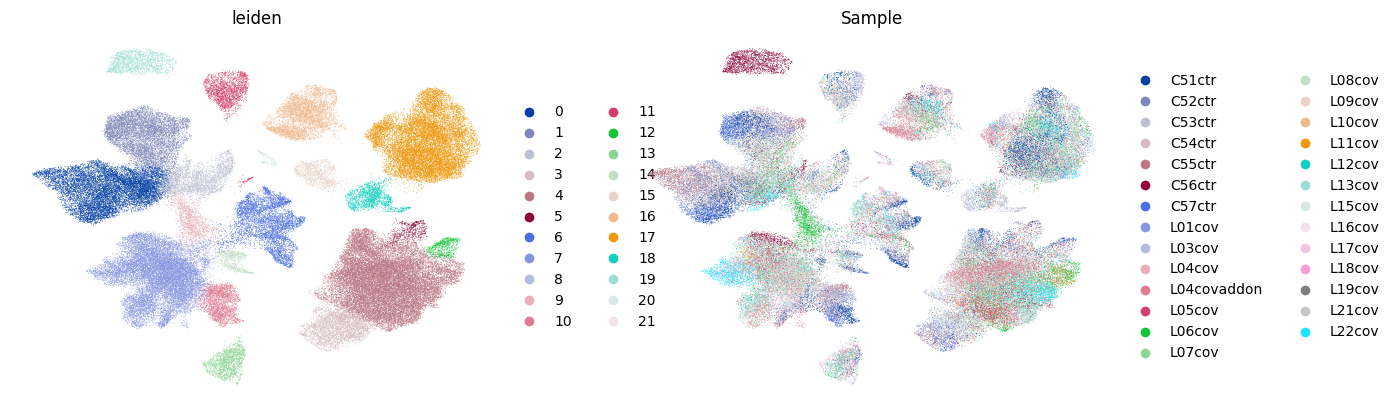

In [32]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

We found 22 Clusters (at a resolution of 0.5) and have a good intergration as we can see that in the Sample all clusters contain cells from different samples (except for one which seems to be special).

In [34]:
# I only do this that i do not need to rerun all the time the clustering again when I load the model!
adata.write_h5ad('integratedSC_dataset_clustered_new.h5ad')

# Cluster Annotation/Label Cell Types

In [1]:
# I started here again because my Kernel crashed. That's why I am reloading the data (luckily I saved the model!). If your data is still in
# the memory you can just continue directly with calling the rank_genes_groups.
import scanpy as sc
import scvi
from scvi.model import SCVI
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

In [4]:
adata = sc.read_h5ad('integratedSC_dataset_clustered_new.h5ad')
model = scvi.model.SCVI.load('path_to_model/', adata=adata)

INFO     File /Users/thorsten/code/ThorstenCodes/Bioinformatics_TK/Projects/First Single Cell                      
         Analysis/Integrated_model/model.pt already downloaded                                                     


/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scvi/model/base/_base_model.py:796: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


**Note:** This next part can be done also if you did not use SCVI to integrate the data. This is base scanpy based on the raw data before the integration via scVI. Further below we show how to determine gene expression via scVI.

In [44]:
# Perform differential gene expression analysis across clusters using Scanpy
# This ranks genes for each cluster (leiden group) compared to all others
sc.tl.rank_genes_groups(adata, 'leiden')

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/s

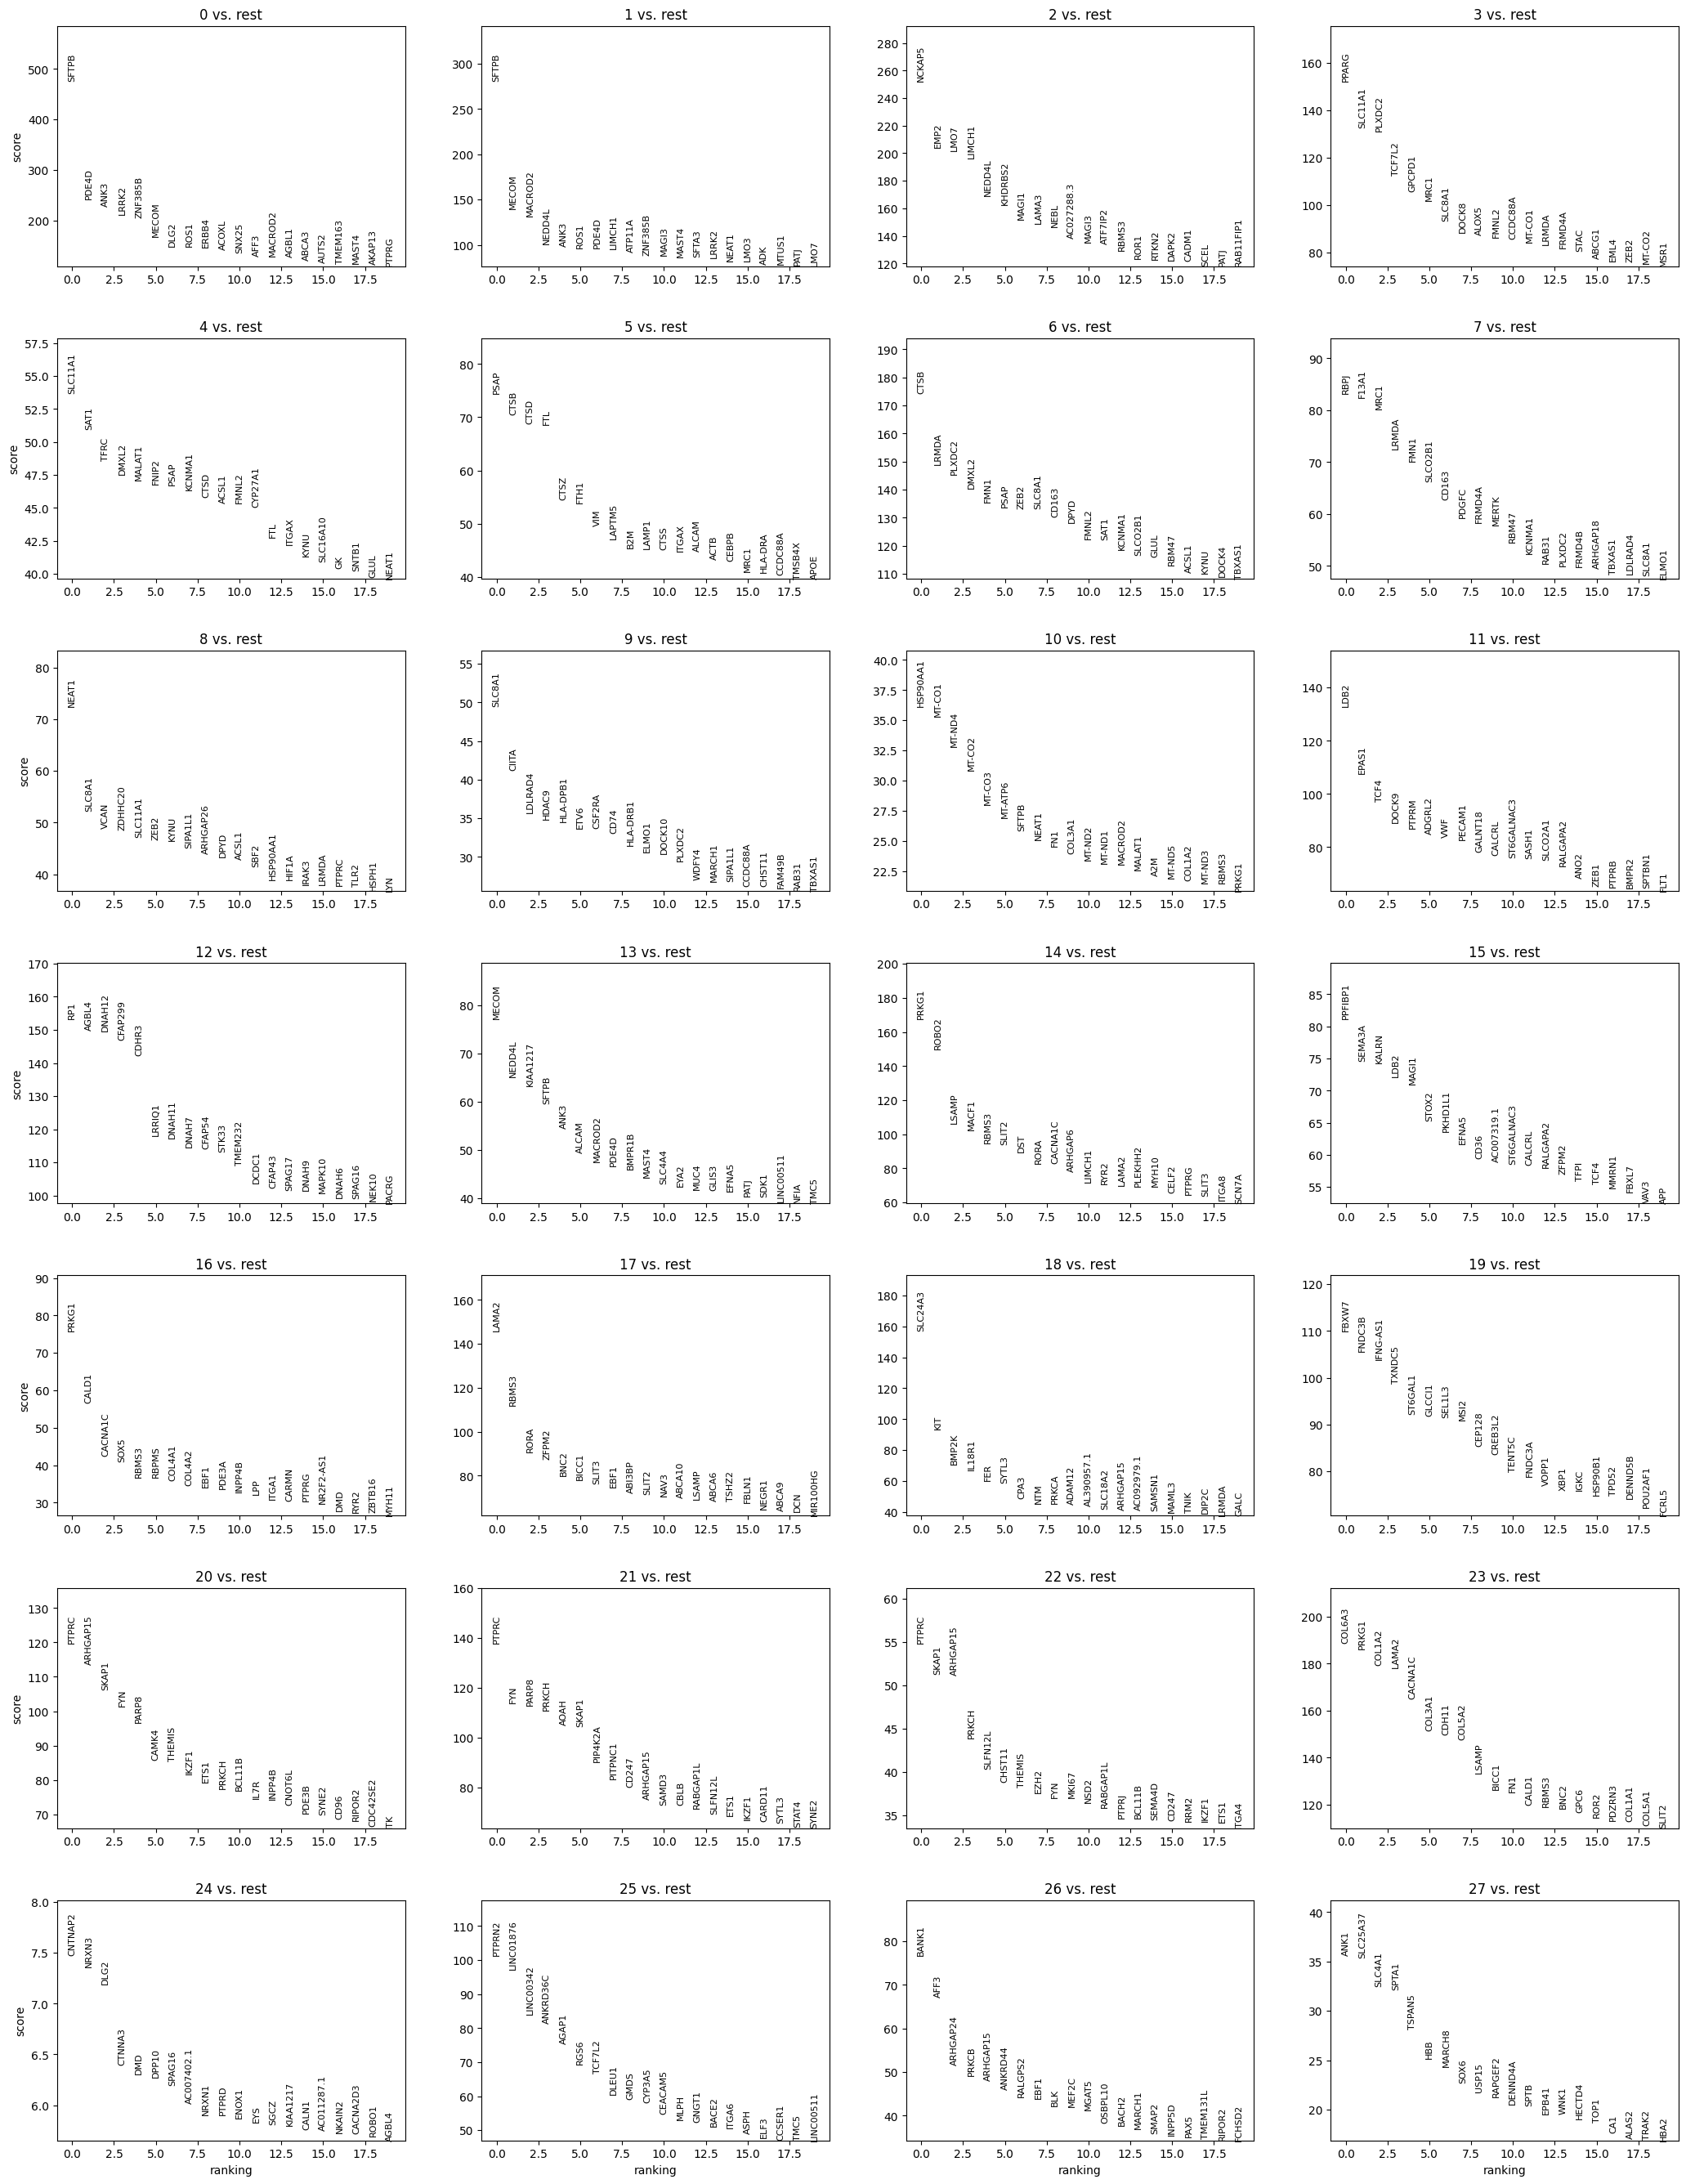

In [45]:
# This shows the top differntial expressed genes in each cluster
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [46]:
# This is a list of all differential regulated genes in the clusters
markers = sc.get.rank_genes_groups_df(adata, None)
#Here we filter for significance
markers = markers[(markers.pvals_adj <0.05) & (markers.logfoldchanges > 0.5)]
markers

group    names      scores  logfoldchanges     pvals  pvals_adj
0          0    SFTPB  475.470551        7.353275  0.000000   0.000000
1          0    PDE4D  242.316956        5.143604  0.000000   0.000000
2          0     ANK3  228.193710        5.375867  0.000000   0.000000
3          0    LRRK2  211.837997        6.314795  0.000000   0.000000
4          0  ZNF385B  205.496750        6.853221  0.000000   0.000000
...      ...      ...         ...             ...       ...        ...
576245    27   PIK3CA    2.098842        0.719219  0.036990   0.048982
576246    27    NEMP1    2.098300        1.378984  0.037039   0.049040
576247    27   RNF187    2.098212        1.959496  0.037048   0.049049
576248    27    IKZF5    2.095298        1.369338  0.037308   0.049384
576249    27    ERCC6    2.091120        1.165048  0.037685   0.049867

[91265 rows x 6 columns]

This dataframe contains a list of differential expressed genes in each cluster compared to all other clusters (Rest). Those can be used to determine of which cell type a cluster is composed. Next I show an alternative using SCVI. <br>
#### NOTE (2025):
Since the publication of scVI, some APIs have changed — older tutorials online 
may use outdated syntax or settings. As of recent versions of `scvi-tools`, it is essential 
to explicitly set `mode='change'` when calling `differential_expression()` to compute full 
differential expression statistics.

🚨 The default mode ('vanilla') only returns basic statistics — it does NOT include 
log fold changes (`lfc_mean`), differential expression probabilities (`proba_de`), or 
FDR-adjusted results (`is_de_fdr_0.05`). <br>

**TL,DR:** <br>
✅ Always set `mode='change'` to obtain the full output.

In [97]:
markers_scvi = model.differential_expression(
    adata=adata,
    groupby='leiden',
    all_stats=True,
    mode='change'
)

DE...:   0%|          | 0/28 [00:00<?, ?it/s]

In [98]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > 0.5)]
markers_scvi

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
AGBL1         0.9884        0.0116      4.445082  0.002728  0.000081   
LHFPL3        0.9880        0.0120      4.410775  0.001166  0.000034   
SNX25         0.9852        0.0148      4.198217  0.002803  0.000289   
LANCL1-AS1    0.9850        0.0150      4.184591  0.000697  0.000049   
LHFPL3-AS2    0.9846        0.0154      4.157867  0.000563  0.000018   
...              ...           ...           ...       ...       ...   
GPLD1         0.8814        0.1186      2.005755  0.000176  0.000011   
SNX9          0.8812        0.1188      2.003843  0.000608  0.000209   
SUZ12         0.8784        0.1216      1.977365  0.000300  0.000109   
HBP1          0.8784        0.1216      1.977365  0.000291  0.000099   
SERINC1       0.8778        0.1222      1.971760  0.000273  0.000063   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
AGBL1           0.000278   0.25  9.673362   10.649891  3.296157  ...   
LHFPL3          0.000278   0.25  7.762552    8.001610  2.582083  ...   
SNX25           0.000278   0.25  3.803998    3.927080  1.306502  ...   
LANCL1-AS1      0.000278   0.25  4.494474    4.536524  1.466427  ...   
LHFPL3-AS2      0.000278   0.25  8.094815    8.762291  2.507131  ...   
...                  ...    ...       ...         ...       ...  ...   
GPLD1           0.000268   0.25  5.051194    5.168036  2.185155  ...   
SNX9            0.000268   0.25  2.253319    1.823116  1.863725  ...   
SUZ12           0.000268   0.25  1.539913    1.588299  0.789756  ...   
HBP1            0.000268   0.25  1.677984    1.712710  0.864662  ...   
SERINC1         0.000268   0.25  2.222842    2.192236  1.173293  ...   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
AGBL1        4.158929   0.077233               0.767053   
LHFPL3       1.978700   0.035624               0.612797   
SNX25        3.709144   0.309125               0.841208   
LANCL1-AS1   1.055220   0.049322               0.496715   
LHFPL3-AS2   0.937892   0.022279               0.432259   
...               ...        ...                    ...   
GPLD1        0.092166   0.010828               0.073733   
SNX9         0.202765   0.299206               0.156682   
SUZ12        0.239631   0.139168               0.207373   
HBP1         0.188940   0.136525               0.142857   
SERINC1      0.239631   0.093860               0.175115   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
AGBL1                    0.019496             28.559118              0.477768   
LHFPL3                   0.016831             12.450522              0.200977   
SNX25                    0.159973             23.716389              2.073801   
LANCL1-AS1               0.035390              7.086142              0.323635   
LHFPL3-AS2               0.011540              5.874076              0.123006   
...                           ...                   ...                   ...   
GPLD1                    0.010046              1.454947              0.079846   
SNX9                     0.196519              3.288907              2.386224   
SUZ12                    0.120409              3.149539              1.086606   
HBP1                     0.118217              3.094105              1.080590   
SERINC1                  0.082565              3.964567              0.679184   

            is_de_fdr_0.05  comparison  group1 group2  
AGBL1                 True   0 vs Rest       0   Rest  
LHFPL3                True   0 vs Rest       0   Rest  
SNX25                 True   0 vs Rest       0   Rest  
LANCL1-AS1            True   0 vs Rest       0   Rest  
LHFPL3-AS2            True   0 vs Rest       0   Rest  
...                    ...         ...     ...    ...  
GPLD1                 True  27 vs Rest      27   Rest  
SNX9                  True  27 vs Rest      27   Rest  
SUZ12                 True  27 vs Rest      27   Rest  
HBP1                  True  27 vs Rest  

In [64]:
# Dictionary for Cluster Labeling 
{"0":"",
"1":"",
"2":"",
"3":"Macrophages",
"4":"Macrophages",
"5":"Macrophages",
"6":"Macrophages",
"7":"Macrophages",
"8":"Monocytes",
"9":"Dendritic cells",
"10":"",
"11":"",
"12":"",
"13":"",
"14":"",
"15":"",
"16":"",
"17":"",
"18":"",
"19":"",
"20":"CD4 T-cells",
"21":"CD8 T-cells",
"22":"",
"23":"",
"24":"",
"25":""}

{'0': '',
 '1': '',
 '2': '',
 '3': 'Macrophages',
 '4': 'Macrophages',
 '5': 'Macrophages',
 '6': 'Macrophages',
 '7': 'Macrophages',
 '8': 'Monocytes',
 '9': 'Dendritic cells',
 '10': '',
 '11': '',
 '12': '',
 '13': '',
 '14': '',
 '15': '',
 '16': '',
 '17': '',
 '18': '',
 '19': '',
 '20': 'CD4 T-cells',
 '21': 'CD8 T-cells',
 '22': '',
 '23': '',
 '24': '',
 '25': ''}

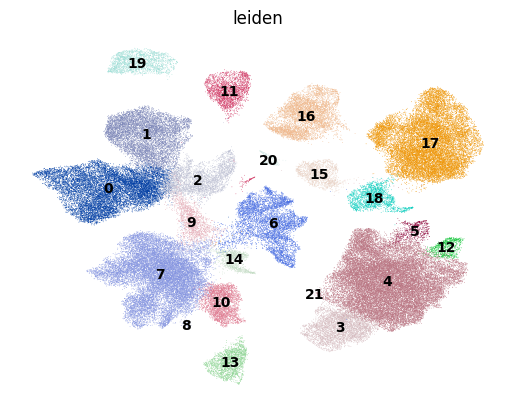

In [25]:
sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc= "on data")

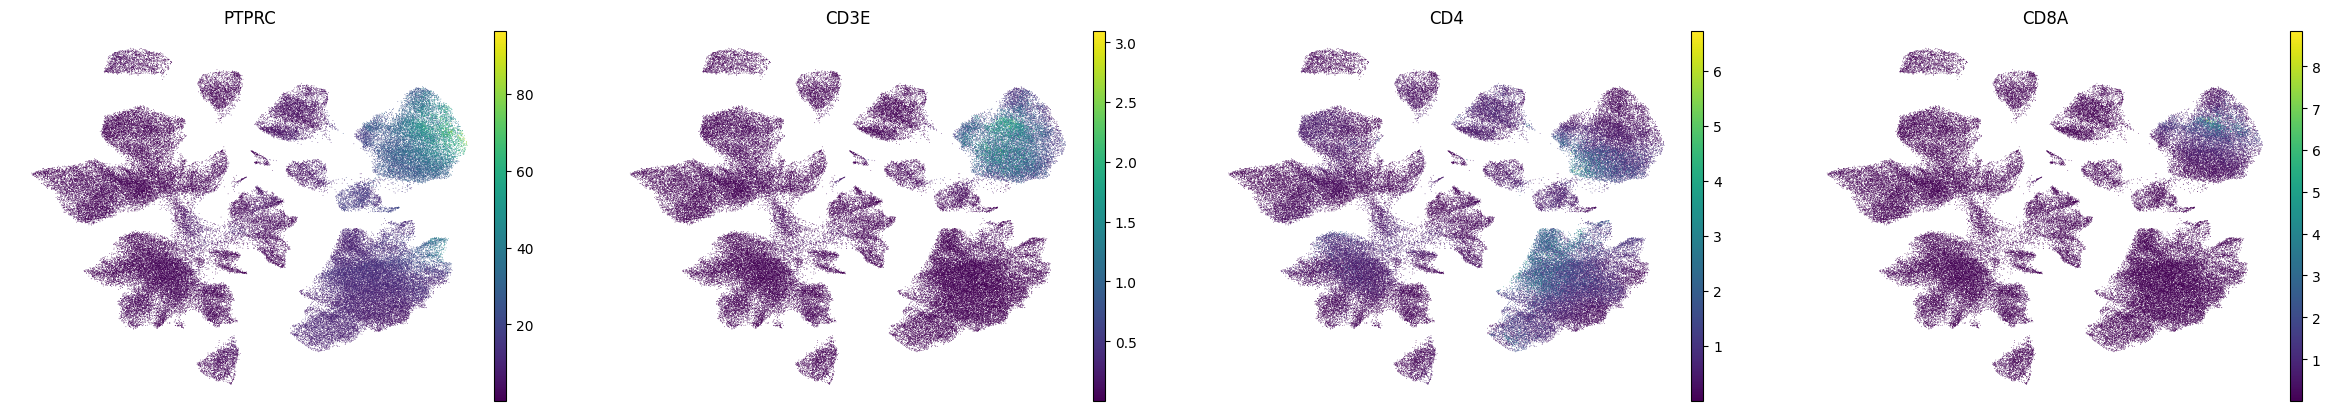

In [32]:
# Check for gene expression in the clusters
# We can use the scvi_noramlized layer or the raw data for this. If we use the scvi_normalized layer we add layer = scvi_normalized
# PTPRC = CD45
sc.pl.umap(adata, color = ['PTPRC', 'CD3E', 'CD4', 'CD8A'], frameon=False, layer = 'scvi_normalized')

Here we see that Cluster 17 are T-cells containing CD4 and CD8 positive T cells. When we want to be able to seperate them
we need to increase the resolution of the clustering. If you find markers that are specificly enriched in a part of a large cluster it is likely that this is a seperate/new cell popultation which is similar to the cell type but transcriptionally different. 
This occurs especially when cells undergo morphology changes such as e.g. Epithelial-mesenchymal transistions (EMT), acinar-ductal metaplasia (ADM) or during differentiation processes or development. If you have enough cells and had a good isolation protocol the dataset might contain cells that have a transient transcriptional state between to cells states. Increasing the resolution can help to identify these populations and how the differ transcriptionally from their origin.
We increase here now the resolution to 1. However, some of the new clusters might collapse again later because they are the same cell type and do not really differ. One needs to look at this manually, best including a biologist or expert which knows different cell states or expression markers. 


In [38]:
sc.tl.leiden(adata, resolution = 1, flavor="igraph", n_iterations=2)

In [40]:
# If you decrease the resolution again the color palette is longer than the clusters you have. Run this line and there will be no error!.
# Remove old color palettes for 'leiden' and 'Sample'
adata.uns.pop('leiden_colors', None)
adata.uns.pop('Sample_colors', None)

array(['#023fa5', '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784', '#8e063b',
       '#4a6fe3', '#8595e1', '#b5bbe3', '#e6afb9', '#e07b91', '#d33f6a',
       '#11c638', '#8dd593', '#c6dec7', '#ead3c6', '#f0b98d', '#ef9708',
       '#0fcfc0', '#9cded6', '#d5eae7', '#f3e1eb', '#f6c4e1', '#f79cd4',
       '#7f7f7f', '#c7c7c7', '#1ce6ff'], dtype=object)

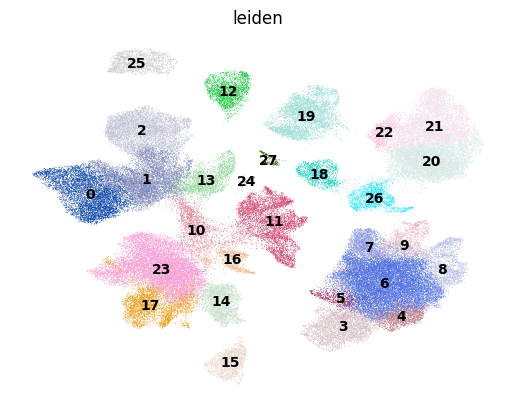

In [43]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc='on data')

In [48]:
markers[markers.names == 'CD8A']

group names     scores  logfoldchanges         pvals     pvals_adj
427224    20  CD8A   7.776503        1.628039  8.407545e-15  1.895568e-14
447718    21  CD8A  21.465879        4.961816  7.676492e-99  4.002823e-98
469799    22  CD8A   8.928442        3.166803  1.202044e-18  3.642549e-18

**Note:** If you don't know markers for cell types check in public literature single cell datasets of the same tissue or check on this website: <br>
https://panglaodb.se/ <br>
They also labeled if they are found only in mouse or human or both. 

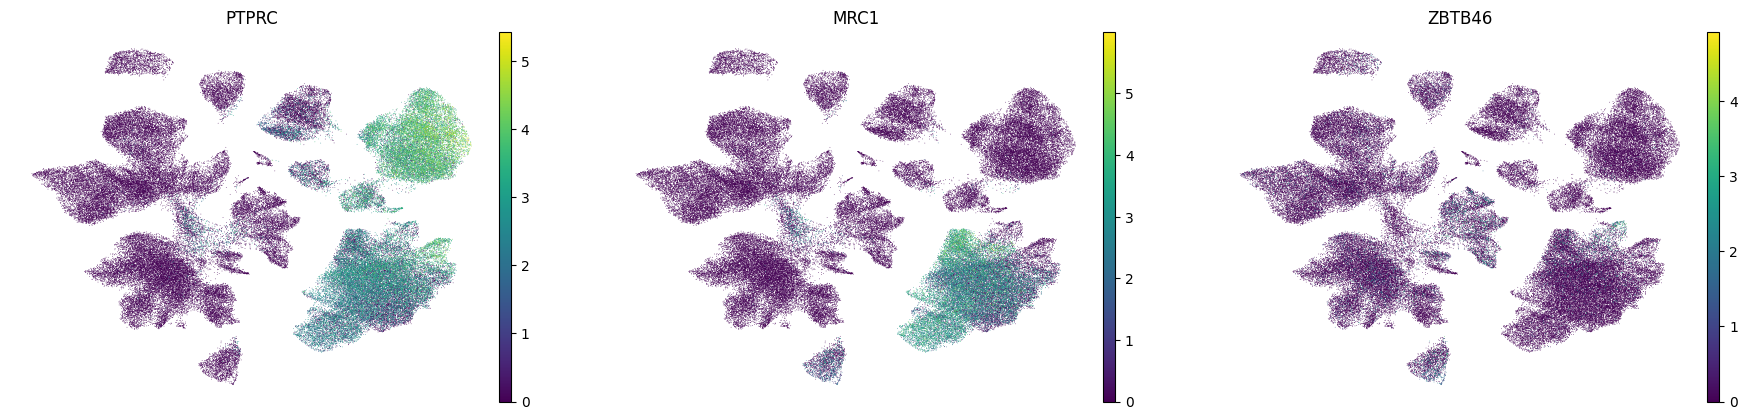

In [56]:
# Lets check this time in the raw data for alveolar macrophages: 
sc.pl.umap(adata, color = ['PTPRC', 'MRC1', 'ZBTB46'], frameon=False)

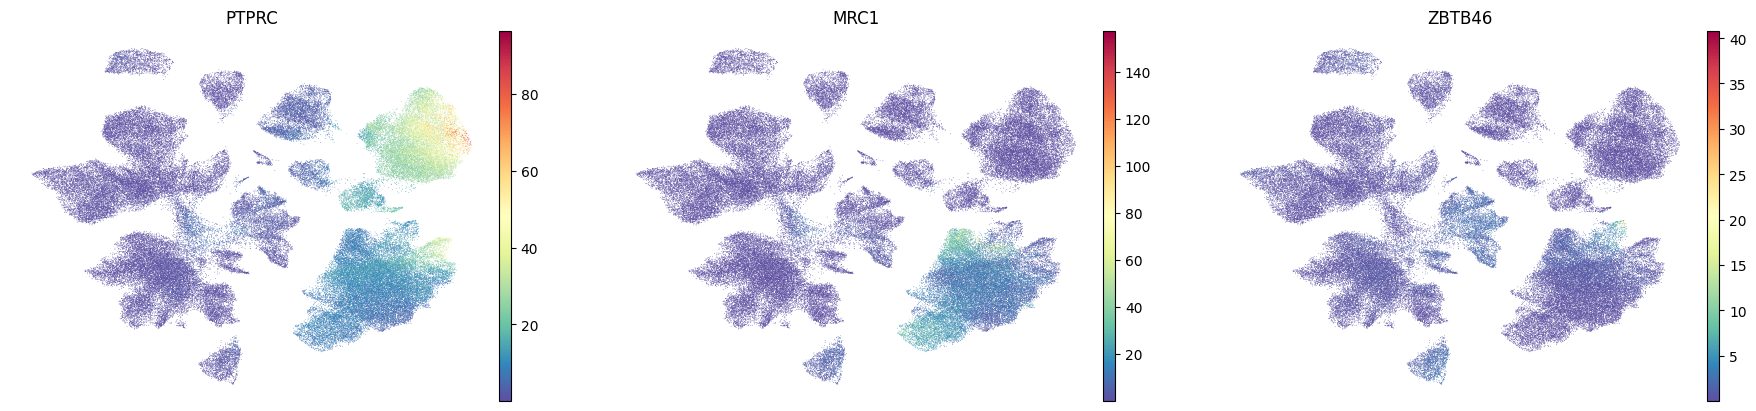

In [59]:
# Let's see if we see it better with normalized dataset and change the color map so we see differences better (default is viridis):
sc.pl.umap(adata, color = ['PTPRC', 'MRC1', 'ZBTB46'], frameon=False, layer = 'scvi_normalized',cmap ='Spectral_r' )

In [60]:
#Check in markers if Cluster 9 are Dendritic cells
markers[markers.names == 'ZBTB46']
# Indeed it has a high fold change! Let's label them Dendritic cells in our dictionary.

group   names     scores  logfoldchanges          pvals      pvals_adj
150417     7  ZBTB46   5.699107        0.821698   1.327123e-08   3.625553e-08
191859     9  ZBTB46  17.138369        3.028075   1.283337e-60   1.300798e-59
214118    10  ZBTB46   3.499418        0.529862   4.745256e-04   1.890118e-03
234678    11  ZBTB46  23.396957        2.485289  3.090113e-115  3.092435e-114
319902    15  ZBTB46  17.195461        2.620075   1.097964e-61   1.102934e-60
341464    16  ZBTB46   6.652553        1.473946   4.411046e-11   1.816072e-10

In [100]:
#You can also confirm in the scvi model like this: 
markers_scvi[markers_scvi.index == 'ZBTB46']

Empty DataFrame
Columns: [proba_de, proba_not_de, bayes_factor, scale1, scale2, pseudocounts, delta, lfc_mean, lfc_median, lfc_std, lfc_min, lfc_max, raw_mean1, raw_mean2, non_zeros_proportion1, non_zeros_proportion2, raw_normalized_mean1, raw_normalized_mean2, is_de_fdr_0.05, comparison, group1, group2]
Index: []

[0 rows x 22 columns]

This is how you go through each cluster and then assign them to the dictionary.

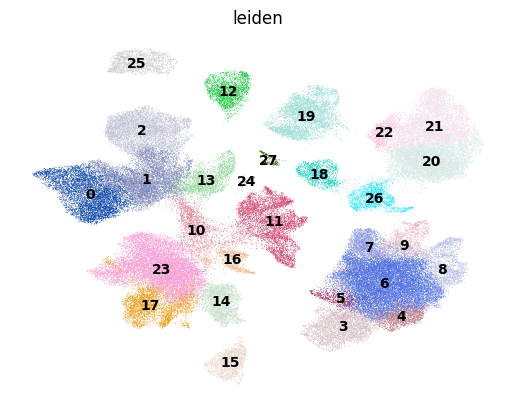

In [67]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc='on data')

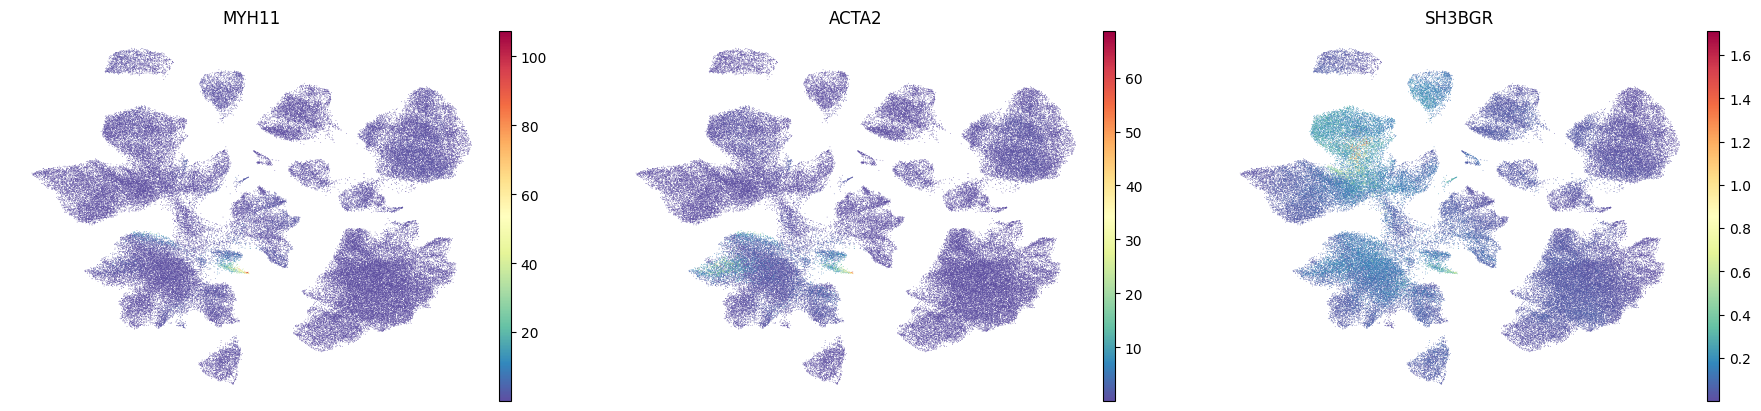

In [147]:
sc.pl.umap(adata, color = ['MYH11', 'ACTA2','SH3BGR'], frameon=False, layer = 'scvi_normalized',cmap ='Spectral_r')

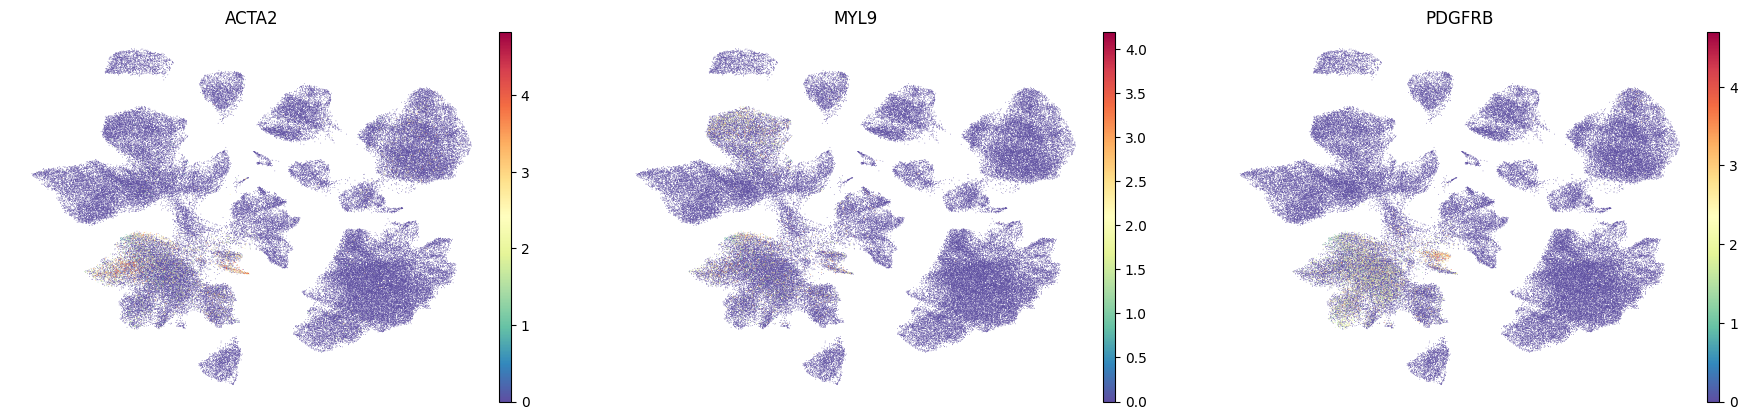

In [90]:
sc.pl.umap(adata, color = ['ACTA2', 'MYL9', 'PDGFRB'], frameon=False,cmap ='Spectral_r' ) #vmax=float

In [119]:
markers[markers.names == 'KIT']

group names     scores  logfoldchanges  pvals  pvals_adj
383509    18   KIT  93.410912       11.597571    0.0        0.0

In [148]:
# If you don't know what cell types are inside:
markers_scvi[markers_scvi.group1 == '24'] 

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
NRXN1       0.9774        0.0226      3.766946  0.000289  0.000004   
PACRG       0.9610        0.0390      3.204413  0.000507  0.000078   
PTPRT       0.9548        0.0452      3.050405  0.000472  0.000076   
AGBL4       0.9450        0.0550      2.843852  0.000656  0.000157   
DNAH12      0.9448        0.0552      2.840010  0.000572  0.000110   
CFAP299     0.9448        0.0552      2.840010  0.000725  0.000121   
DNAH3       0.9416        0.0584      2.780265  0.000321  0.000051   
AQP4-AS1    0.9410        0.0590      2.769406  0.000478  0.000067   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
NRXN1         0.000286   0.25  7.331542    7.675075  2.221380  ...   0.760417   
PACRG         0.000286   0.25  5.748821    5.772733  3.120852  ...   0.354167   
PTPRT         0.000286   0.25  6.553769    7.025606  2.899870  ...   0.677083   
AGBL4         0.000286   0.25  4.916265    5.181427  2.768303  ...   0.864583   
DNAH12        0.000286   0.25  6.416361    6.642792  2.899892  ...   0.531250   
CFAP299       0.000286   0.25  6.334631    6.523694  3.037327  ...   0.510417   
DNAH3         0.000286   0.25  5.826243    5.947902  2.530151  ...   0.281250   
AQP4-AS1      0.000286   0.25  6.418926    6.910658  2.953746  ...   0.322917   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
NRXN1      0.001214               0.281250               0.000782   
PACRG      0.093243               0.166667               0.029183   
PTPRT      0.099332               0.250000               0.019167   
AGBL4      0.209137               0.322917               0.040809   
DNAH12     0.165673               0.177083               0.023720   
CFAP299    0.174990               0.218750               0.022552   
DNAH3      0.064107               0.166667               0.020740   
AQP4-AS1   0.134769               0.187500               0.029119   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
NRXN1                 4.864467              0.009372            True   
PACRG                 2.484992              0.539827            True   
PTPRT                 4.238813              0.570601            True   
AGBL4                 6.367459              1.208614            True   
DNAH12                3.227547              0.936906            True   
CFAP299               3.213195              0.968361            True   
DNAH3                 2.155884              0.354137            True   
AQP4-AS1              2.100464              0.711497            True   

          comparison  group1 group2  
NRXN1     24 vs Rest      24   Rest  
PACRG     24 vs Rest      24   Rest  
PTPRT     24 vs Rest      24   Rest  
AGBL4     24 vs Rest      24   Rest  
DNAH12    24 vs Rest      24   Rest  
CFAP299   24 vs Rest      24   Rest  
DNAH3     24 vs Rest      24   Rest  
AQP4-AS1  24 vs Rest      24   Rest  

[8 rows x 22 columns]

In [149]:
# Print a list with commas in between gene names for Panglao DB Search:
items = markers_scvi[markers_scvi.group1 == '24'][0:13].index
print(','.join(str(item) for item in items))

NRXN1,PACRG,PTPRT,AGBL4,DNAH12,CFAP299,DNAH3,AQP4-AS1


In [150]:
for item in markers_scvi[markers_scvi.group1 == '24'][0:1000].index:
    print(item)


NRXN1
PACRG
PTPRT
AGBL4
DNAH12
CFAP299
DNAH3
AQP4-AS1


In [164]:
# Dictionary for Cluster Labeling 
cell_type = {"0":"AT2",
"1":"AT2",
"2":"AT1",
"3":"Macrophages",
"4":"Macrophages",
"5":"Macrophages",
"6":"Macrophages",
"7":"Macrophages",
"8":"Monocytes/Neutrophils",
"9":"Dendritic cells",
"10":"Airway Epithelial",
"11":"Endothelial cells",
"12":"Ciliated Cells",
"13":"Goblet Cells",
"14":"Fibroblasts",
"15":"Lymphatic Endothel",
"16":"Smooth Muscle Cells",
"17":"Fibroblasts",
"18":"Mast Cells",
"19":"Plasma Cells",
"20":"CD4 T-cells",
"21":"CD8 T-cells",
"22":"Cycling NK/T-Cells",
"23":"Fibroblasts",
"24":"Neuronal Cells",
"25":"Epithelial",
"26":"B-Cells"}

In [165]:
adata.obs['cell_type'] = adata.obs.leiden.map(cell_type)

In [167]:
adata.uns.pop('cell_type_colors', None)

['#023fa5',
 '#7d87b9',
 '#bec1d4',
 '#d6bcc0',
 '#bb7784',
 '#8e063b',
 '#4a6fe3',
 '#8595e1',
 '#b5bbe3',
 '#e6afb9',
 '#e07b91',
 '#d33f6a',
 '#11c638',
 '#8dd593',
 '#c6dec7',
 '#ead3c6',
 '#f0b98d',
 '#ef9708',
 '#0fcfc0',
 '#9cded6',
 '#d5eae7']

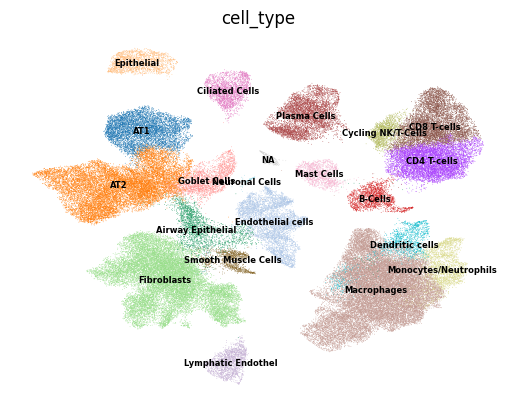

In [168]:
sc.pl.umap(adata, color = ['cell_type'], frameon = False, legend_loc='on data',legend_fontsize=6)

In [170]:
adata.uns['scvi_markers']= markers_scvi
adata.uns['markers'] = markers

In [171]:
adata.write_h5ad('integratedSC_dataset_clustered_new.h5ad')

In [175]:
model.save('complete_model')

# Analysis

In [ ]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

## Counting Cells

In [178]:
adata.obs.Sample.unique().tolist()

['C57ctr',
 'L18cov',
 'L12cov',
 'L11cov',
 'L06cov',
 'L17cov',
 'L13cov',
 'C52ctr',
 'C55ctr',
 'L01cov',
 'L19cov',
 'L03cov',
 'L21cov',
 'L15cov',
 'L16cov',
 'L10cov',
 'L22cov',
 'L07cov',
 'C56ctr',
 'L08cov',
 'L04cov',
 'C54ctr',
 'C53ctr',
 'L04covaddon',
 'L09cov',
 'L05cov',
 'C51ctr']

In [179]:
def map_condition(x):
    if 'cov' in x:
        return 'COVID19'
    else:
        return 'control'

In [180]:
adata.obs['condition'] = adata.obs.Sample.map(map_condition)

In [193]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_29882/2419454245.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['Sample']).count()


{'C51ctr': 5960,
 'C52ctr': 4415,
 'C53ctr': 6928,
 'C54ctr': 4284,
 'C55ctr': 5565,
 'C56ctr': 3904,
 'C57ctr': 4687,
 'L01cov': 2952,
 'L03cov': 3953,
 'L04cov': 3401,
 'L04covaddon': 4386,
 'L05cov': 2696,
 'L06cov': 6306,
 'L07cov': 4753,
 'L08cov': 3767,
 'L09cov': 3368,
 'L10cov': 1501,
 'L11cov': 2888,
 'L12cov': 3648,
 'L13cov': 4732,
 'L15cov': 3905,
 'L16cov': 1773,
 'L17cov': 4341,
 'L18cov': 2633,
 'L19cov': 2429,
 'L21cov': 3257,
 'L22cov': 6390}

In [199]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell_type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_29882/3057977852.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell_type']).count()


Sample condition              cell_type  doublet
0    C51ctr   control                    AT1      795
1    C51ctr   control                    AT2      810
2    C51ctr   control      Airway Epithelial       21
3    C51ctr   control                B-Cells       38
4    C51ctr   control            CD4 T-cells      736
..      ...       ...                    ...      ...
499  L22cov   COVID19             Mast Cells        8
500  L22cov   COVID19  Monocytes/Neutrophils      184
501  L22cov   COVID19         Neuronal Cells        3
502  L22cov   COVID19           Plasma Cells      539
503  L22cov   COVID19    Smooth Muscle Cells       70

[504 rows x 4 columns]

In [208]:
# Rename column
cell_type_counts = cell_type_counts.rename(columns={'doublet' : 'cell_type_counts'})

In [209]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts.cell_type_counts/cell_type_counts.total_cells
cell_type_counts

Sample condition              cell_type  cell_type_counts  total_cells  \
0    C51ctr   control                    AT1               795         5960   
1    C51ctr   control                    AT2               810         5960   
2    C51ctr   control      Airway Epithelial                21         5960   
3    C51ctr   control                B-Cells                38         5960   
4    C51ctr   control            CD4 T-cells               736         5960   
..      ...       ...                    ...               ...          ...   
499  L22cov   COVID19             Mast Cells                 8         6390   
500  L22cov   COVID19  Monocytes/Neutrophils               184         6390   
501  L22cov   COVID19         Neuronal Cells                 3         6390   
502  L22cov   COVID19           Plasma Cells               539         6390   
503  L22cov   COVID19    Smooth Muscle Cells                70         6390   

     frequency  
0     0.133389  
1     0.135906  
2     0.003523  
3     0.006376  
4     0.123490  
..         ...  
499   0.001252  
500   0.028795  
501   0.000469  
502   0.084351  
503   0.010955  

[504 rows x 6 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

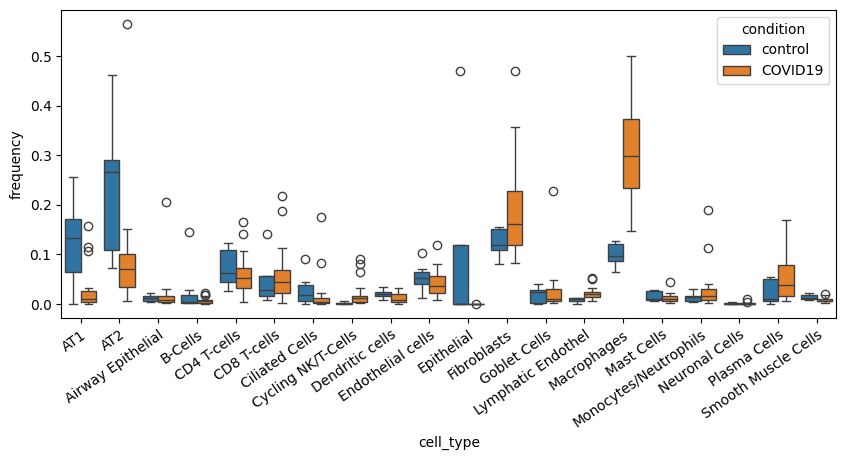

In [210]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
ax = sns.boxplot(data = cell_type_counts, x = 'cell_type', y='frequency', hue = 'condition')
plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')
plt.show

## Differential Expression/Heatmaps using SCVI

In [223]:
subset = adata[adata.obs['cell_type'].isin(['AT1', 'AT2'])].copy()

In [ ]:
#model = scvi.model.SCVI.load('model', adata)

In [213]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [216]:
scvi_de = model.differential_expression(
    idx1 = [adata.obs['cell_type'] == 'AT1'],
    idx2 = [adata.obs['cell_type'] == 'AT2'],
    mode = 'change'
)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [217]:
scvi_de

proba_de  proba_not_de  bayes_factor    scale1        scale2  \
ATF7IP2       0.9892        0.0108      4.517349  0.002767  1.298958e-04   
TTLL7         0.9850        0.0150      4.184591  0.000402  2.020917e-05   
EPS8          0.9844        0.0156     -4.144761  0.000064  9.738192e-04   
ROS1          0.9830        0.0170     -4.057395  0.000142  2.366700e-03   
EMP2          0.9822        0.0178      4.010596  0.003430  2.958021e-04   
...              ...           ...           ...       ...           ...   
AC084125.2    0.0000        1.0000     -0.000000  0.000002  3.117621e-06   
KIF19         0.0000        1.0000     -0.000000  0.000001  9.413126e-07   
GPT           0.0000        1.0000     -0.000000  0.000001  2.049191e-06   
TTYH2         0.0000        1.0000     -0.000000  0.000001  3.120027e-06   
AL627309.1    0.0000        1.0000     -0.000000  0.000001  2.737634e-06   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std   lfc_min  \
ATF7IP2         0.000123   0.25  4.931863    5.132309  1.710865 -3.155439   
TTLL7           0.000123   0.25  6.499790    7.021041  2.658972 -2.699593   
EPS8            0.000123   0.25 -4.180127   -4.378473  1.476733 -7.842371   
ROS1            0.000123   0.25 -4.523823   -4.798690  1.627749 -8.366994   
EMP2            0.000123   0.25  4.244181    4.360562  1.695248 -2.304108   
...                  ...    ...       ...         ...       ...       ...   
AC084125.2      0.000123   0.25 -0.328707   -0.362276  1.031130 -4.336989   
KIF19           0.000123   0.25  0.283894    0.346606  1.229266 -4.702187   
GPT             0.000123   0.25 -0.599707   -0.623542  1.188513 -4.966094   
TTYH2           0.000123   0.25 -1.053217   -1.092935  1.283744 -5.529583   
AL627309.1      0.000123   0.25 -1.151645   -1.235878  0.930288 -4.275854   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
ATF7IP2      9.356086   5.588781   0.311943               0.839013   
TTLL7       12.213140   0.668461   0.038830               0.404230   
EPS8         2.739326   0.072352   1.398585               0.053215   
ROS1         3.501629   0.038778   2.993717               0.020312   
EMP2         8.834702   5.619999   0.495492               0.923619   
...               ...        ...        ...                    ...   
AC084125.2   3.431288   0.002014   0.003121               0.002014   
KIF19        5.157660   0.000168   0.000363               0.000168   
GPT          4.148024   0.001343   0.001960               0.001343   
TTYH2        3.802057   0.001511   0.004718               0.001343   
AL627309.1   2.653683   0.000839   0.002758               0.000839   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
ATF7IP2                  0.179707             34.638210              1.623081   
TTLL7                    0.030629              4.444487              0.221789   
EPS8                     0.549790              0.311907              8.176568   
ROS1                     0.735375              0.135666             17.618113   
EMP2                     0.245101             37.763290              2.939320   
...                           ...                   ...                   ...   
AC084125.2               0.003048              0.014863              0.020632   
KIF19                    0.000363              0.000673              0.002871   
GPT                      0.001960              0.012047              0.013233   
TTYH2                    0.004645              0.008959              0.025414   
AL627309.1               0.002758              0.004254              0.019851   

            is_de_fdr_0.05  
ATF7IP2               True  
TTLL7                 True  
EPS8                  True  
ROS1                  True  
EMP2                  True  
...                    ...  
AC084125.2           False  
KIF19                False  
GPT                  False  
TTYH2                False  
AL627309.1           False  

[21306 rows

In [219]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) >0.5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
CSF3R         0.9308        0.0692     -2.599043  0.000006  0.000438   
LAMP3         0.9460        0.0540     -2.863258  0.000010  0.000469   
TMEM163       0.9696        0.0304     -3.462441  0.000028  0.001258   
SFTPA1        0.9566        0.0434     -3.092926  0.000024  0.000925   
SFTPA2        0.9496        0.0504     -2.936049  0.000030  0.001127   
...              ...           ...           ...       ...       ...   
SYT1          0.9696        0.0304      3.462441  0.000309  0.000011   
NCKAP5-AS2    0.9762        0.0238      3.713981  0.000441  0.000014   
AC095050.1    0.9484        0.0516      2.911254  0.000218  0.000010   
TTLL7         0.9850        0.0150      4.184591  0.000402  0.000020   
AL355499.1    0.9718        0.0282      3.539828  0.001026  0.000056   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
CSF3R           0.000123   0.25 -7.226024   -7.728616  2.571152 -12.635159   
LAMP3           0.000123   0.25 -6.789381   -7.240594  2.573395 -12.271083   
TMEM163         0.000123   0.25 -6.654840   -6.961304  2.571002 -13.547029   
SFTPA1          0.000123   0.25 -6.081588   -6.331892  2.587362 -14.821315   
SFTPA2          0.000123   0.25 -5.552751   -5.662071  2.557747 -14.695595   
...                  ...    ...       ...         ...       ...        ...   
SYT1            0.000123   0.25  6.019574    6.239121  2.385604  -4.527252   
NCKAP5-AS2      0.000123   0.25  6.091539    6.345378  2.323699  -3.184312   
AC095050.1      0.000123   0.25  6.105087    6.524037  2.364819  -5.439623   
TTLL7           0.000123   0.25  6.499790    7.021041  2.658972  -2.699593   
AL355499.1      0.000123   0.25  6.545271    7.087963  2.768290  -4.777919   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
CSF3R        5.697643   0.003861   0.558780               0.003525   
LAMP3        5.099307   0.006043   0.545789               0.005372   
TMEM163      5.041201   0.028706   1.869946               0.016451   
SFTPA1       4.821287   0.007218   1.262464               0.001343   
SFTPA2       3.884521   0.009233   1.581527               0.002182   
...               ...        ...        ...                    ...   
SYT1        11.830265   0.526780   0.017927               0.304348   
NCKAP5-AS2  12.485679   0.803256   0.010814               0.348330   
AC095050.1  11.292177   0.304855   0.006024               0.217895   
TTLL7       12.213140   0.668461   0.038830               0.404230   
AL355499.1  13.292192   1.593910   0.052475               0.625147   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
CSF3R                    0.347873              0.018123              3.564811   
LAMP3                    0.320438              0.025968              3.238963   
TMEM163                  0.612353              0.109594             11.695893   
SFTPA1                   0.318551              0.022228              6.836874   
SFTPA2                   0.295326              0.035664              8.325827   
...                           ...                   ...                   ...   
SYT1                     0.013718              3.278310              0.081913   
NCKAP5-AS2               0.008129              4.978723              0.062794   
AC095050.1               0.004790              2.164983              0.040708   
TTLL7                    0.030629              4.444487              0.221789   
AL355499.1               0.029177             10.212195              0.319569   

            is_de_fdr_0.05  
CSF3R                 True  
LAMP3                 True  
TMEM163               True  
SFTPA1                True  
SFTPA2                True  
...                    ...  
SYT1                  True  
NCKAP5-AS2            True  
AC095050.1            True  
TTLL7                 True  
AL355499.1            True  

[227 rows x 19 columns]

In [220]:
scvi_de = scvi_de[(scvi_de.raw_normalized_mean1 > .5) | (scvi_de.raw_normalized_mean2 > .5)]
scvi_de

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
CSF3R         0.9308        0.0692     -2.599043  0.000006  0.000438   
LAMP3         0.9460        0.0540     -2.863258  0.000010  0.000469   
TMEM163       0.9696        0.0304     -3.462441  0.000028  0.001258   
SFTPA1        0.9566        0.0434     -3.092926  0.000024  0.000925   
SFTPA2        0.9496        0.0504     -2.936049  0.000030  0.001127   
...              ...           ...           ...       ...       ...   
SYT1          0.9696        0.0304      3.462441  0.000309  0.000011   
NCKAP5-AS2    0.9762        0.0238      3.713981  0.000441  0.000014   
AC095050.1    0.9484        0.0516      2.911254  0.000218  0.000010   
TTLL7         0.9850        0.0150      4.184591  0.000402  0.000020   
AL355499.1    0.9718        0.0282      3.539828  0.001026  0.000056   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
CSF3R           0.000123   0.25 -7.226024   -7.728616  2.571152 -12.635159   
LAMP3           0.000123   0.25 -6.789381   -7.240594  2.573395 -12.271083   
TMEM163         0.000123   0.25 -6.654840   -6.961304  2.571002 -13.547029   
SFTPA1          0.000123   0.25 -6.081588   -6.331892  2.587362 -14.821315   
SFTPA2          0.000123   0.25 -5.552751   -5.662071  2.557747 -14.695595   
...                  ...    ...       ...         ...       ...        ...   
SYT1            0.000123   0.25  6.019574    6.239121  2.385604  -4.527252   
NCKAP5-AS2      0.000123   0.25  6.091539    6.345378  2.323699  -3.184312   
AC095050.1      0.000123   0.25  6.105087    6.524037  2.364819  -5.439623   
TTLL7           0.000123   0.25  6.499790    7.021041  2.658972  -2.699593   
AL355499.1      0.000123   0.25  6.545271    7.087963  2.768290  -4.777919   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
CSF3R        5.697643   0.003861   0.558780               0.003525   
LAMP3        5.099307   0.006043   0.545789               0.005372   
TMEM163      5.041201   0.028706   1.869946               0.016451   
SFTPA1       4.821287   0.007218   1.262464               0.001343   
SFTPA2       3.884521   0.009233   1.581527               0.002182   
...               ...        ...        ...                    ...   
SYT1        11.830265   0.526780   0.017927               0.304348   
NCKAP5-AS2  12.485679   0.803256   0.010814               0.348330   
AC095050.1  11.292177   0.304855   0.006024               0.217895   
TTLL7       12.213140   0.668461   0.038830               0.404230   
AL355499.1  13.292192   1.593910   0.052475               0.625147   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
CSF3R                    0.347873              0.018123              3.564811   
LAMP3                    0.320438              0.025968              3.238963   
TMEM163                  0.612353              0.109594             11.695893   
SFTPA1                   0.318551              0.022228              6.836874   
SFTPA2                   0.295326              0.035664              8.325827   
...                           ...                   ...                   ...   
SYT1                     0.013718              3.278310              0.081913   
NCKAP5-AS2               0.008129              4.978723              0.062794   
AC095050.1               0.004790              2.164983              0.040708   
TTLL7                    0.030629              4.444487              0.221789   
AL355499.1               0.029177             10.212195              0.319569   

            is_de_fdr_0.05  
CSF3R                 True  
LAMP3                 True  
TMEM163               True  
SFTPA1                True  
SFTPA2                True  
...                    ...  
SYT1                  True  
NCKAP5-AS2            True  
AC095050.1            True  
TTLL7                 True  
AL355499.1            True  

[227 rows x 19 columns]

In [227]:
#Generate a list with the Top 25 up and downregulated genes of the dataframe
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist()

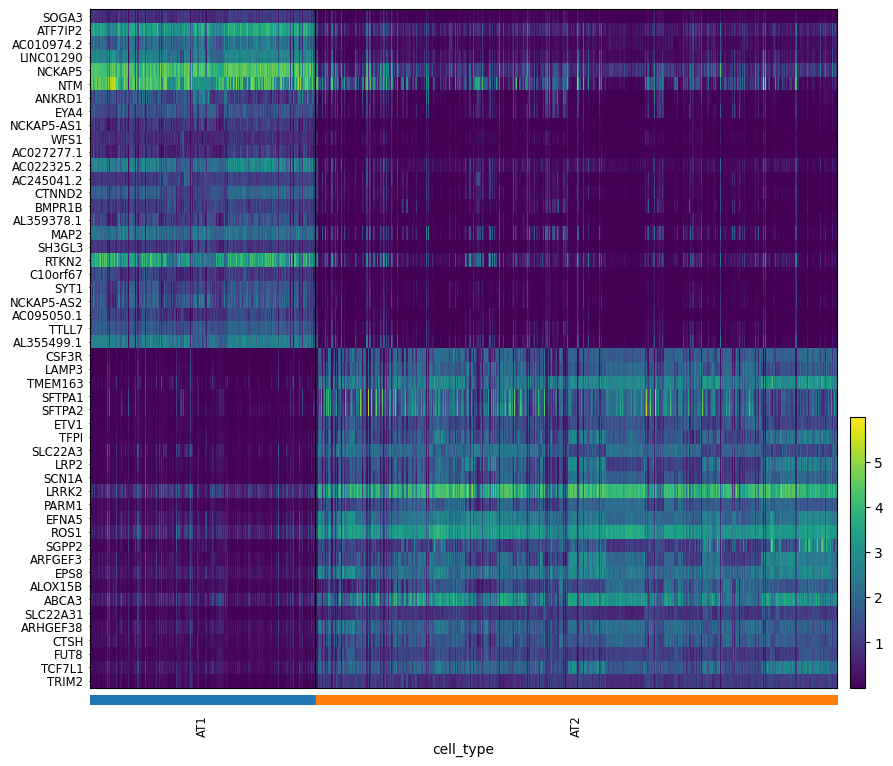

In [228]:
sc.pl.heatmap(subset, genes_to_show, groupby = 'cell_type', swap_axes=True, layer= 'scvi_normalized', log=True)

In [229]:
subset

AnnData object with n_obs × n_vars = 19735 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type', 'condition'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap', 'rank_genes_groups', 'leiden_colors', 'Sample_colors', 'cell_type_colors', 'scvi_markers', 'markers'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

## Enrichment analysis in python (GO, KEGG,...)

In [231]:
import gseapy as gp #this method requires internet connection

In [232]:
gp.get_library_name()
# KEGG_2021_Human
# MSigDB_Hallmark_2020
# GO_Biological_Process_2023
# ....

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'COMPARTMENTS_Curated_2025',
 'COMPARTMENTS_Experimental_2025',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Scre

In [233]:
subset

AnnData object with n_obs × n_vars = 19735 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type', 'condition'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'umap', 'rank_genes_groups', 'leiden_colors', 'Sample_colors', 'cell_type_colors', 'scvi_markers', 'markers'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

['PATJ',
 'CTNND1',
 'MAGI1',
 'TMCC1',
 'ALCAM',
 'TJP1',
 'RASAL2',
 'FARP1',
 'ABLIM1',
 'PARVA',
 'FAM107B',
 'WWC2',
 'GPRC5A',
 'SLC35A3',
 'RGL1',
 'TTC7A',
 'MYO5B',
 'SPTBN1',
 'QKI',
 'PLEKHA1',
 'CTIF',
 'ZFYVE9',
 'JADE1',
 'UBL3',
 'EPB41L5',
 'DOCK4',
 'LATS2',
 'PEAK1',
 'RBMS3',
 'DAPK2',
 'NMD3',
 'FZD6',
 'AC112206.2',
 'LMO7',
 'TNS3',
 'APBB2',
 'PLEKHH2',
 'COL4A4',
 'DMD',
 'TBC1D9',
 'IQCJ-SCHIP1',
 'RAB11FIP1',
 'PFDN1',
 'PAPSS2',
 'TMOD3',
 'IL18',
 'HULC',
 'UNC13D',
 'DENND3',
 'EPB41L3',
 'COL4A3',
 'RETREG1',
 'PALM2-AKAP2',
 'CYP4B1',
 'HEG1',
 'AGTPBP1',
 'AC044810.2',
 'RGS6',
 'MYO1C',
 'ROR1',
 'MYO16-AS1',
 'FHL1',
 'GALNT18',
 'WASF3',
 'PPFIBP1',
 'DST',
 'ABCC1',
 'SMYD2',
 'OVCH2',
 'AC097662.1',
 'LAMA3',
 'CLIC5',
 'FRMD3',
 'LRRC1',
 'MYO16',
 'NRG1',
 'ANKRD29',
 'RP1',
 'GRK5',
 'ARHGEF26-AS1',
 'CAV2',
 'ANOS1',
 'PTPN21',
 'CNTN6',
 'ARHGEF26',
 'SCD5',
 'GPM6A',
 'CCBE1',
 'SEMA5A',
 'VEGFA',
 'CAV1',
 'RGCC',
 'TMEM258',
 'SPOCK2',
 'AC0

In [243]:
enr = gp.enrichr(gene_list = scvi_de[scvi_de.lfc_mean > 0].index.tolist(), 
                 gene_sets = ['KEGG_2021_Human', 'MSigDB_Hallmark_2020'],
                 organism = 'human',
                 outdir = None,
                 background = subset.var_names.tolist()
                )


In [244]:
enr.results

Gene_set                                               Term  \
0         KEGG_2021_Human                                     Focal adhesion   
1         KEGG_2021_Human  AGE-RAGE signaling pathway in diabetic complic...   
2         KEGG_2021_Human                     Human papillomavirus infection   
3         KEGG_2021_Human                                  Adherens junction   
4         KEGG_2021_Human                   Mucin type O-glycan biosynthesis   
..                    ...                                                ...   
137  MSigDB_Hallmark_2020                                Allograft Rejection   
138  MSigDB_Hallmark_2020                                  KRAS Signaling Up   
139  MSigDB_Hallmark_2020                              Inflammatory Response   
140  MSigDB_Hallmark_2020                                       Adipogenesis   
141  MSigDB_Hallmark_2020                          Interferon Gamma Response   

      P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
0    0.000005          0.000585            0                     0   
1    0.000053          0.002920            0                     0   
2    0.000744          0.027284            0                     0   
3    0.001233          0.027451            0                     0   
4    0.001248          0.027451            0                     0   
..        ...               ...          ...                   ...   
137  0.699417          0.731988            0                     0   
138  0.715207          0.731988            0                     0   
139  0.720913          0.731988            0                     0   
140  0.726506          0.731988            0                     0   
141  0.731988          0.731988            0                     0   

     Odds Ratio  Combined Score  \
0      7.844764       95.273620   
1      9.995731       98.391394   
2      4.420874       31.844976   
3      9.265700       62.063062   
4     15.729348      105.172732   
..          ...             ...   
137    0.836162        0.298934   
138    0.799893        0.268111   
139    0.787084        0.257562   
140    0.774675        0.247515   
141    0.762648        0.237940   

                                                 Genes  
0    COL4A2;CAV2;COL4A4;CAV1;COL4A3;LAMA3;PARVA;MYL...  
1                COL4A2;COL4A4;COL4A3;PLCE1;AGER;VEGFA  
2     MAGI1;PATJ;COL4A2;COL4A4;FZD6;COL4A3;LAMA3;VEGFA  
3                               TJP1;CTNND1;LMO7;WASF3  
4                           GALNT13;GALNT18;ST6GALNAC3  
..                                                 ...  
137                                               IL18  
138                                            EPB41L3  
139                                               IL18  
140                                             CYP4B1  
141                                              LATS2  

[142 rows x 9 columns]

In [262]:
enr.results['1-log10(adjP)'] = (1- np.log10(enr.results['Adjusted P-value']))

In [269]:
1- np.log10(0.05)

2.3010299956639813

/var/folders/vn/wdw36m4d5k13n07b5xlhgmsr0000gn/T/ipykernel_29882/1702045429.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


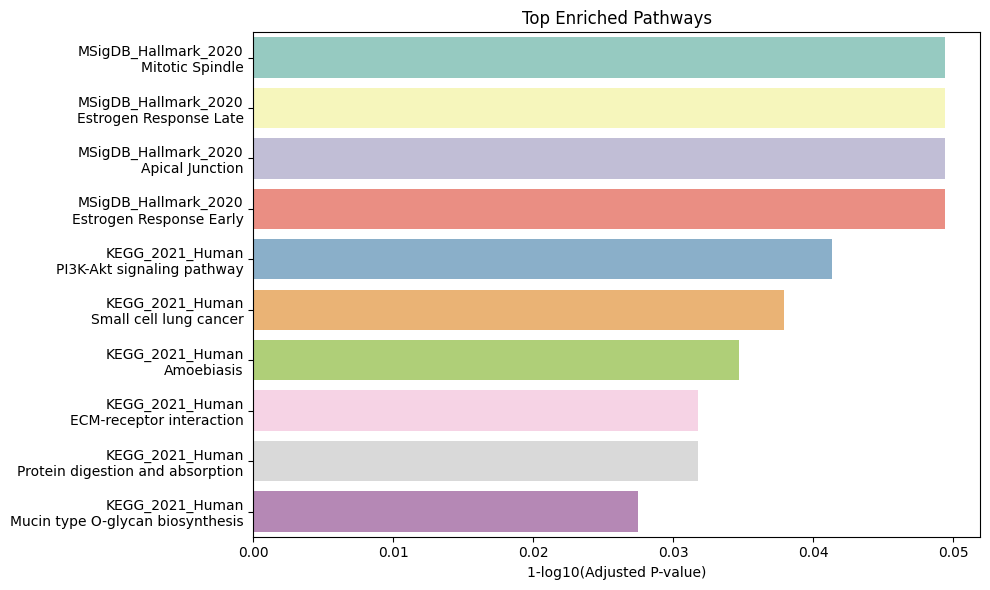

In [272]:
# Filter and sort top significant rows
df = enr.results[enr.results['1-log10(adjP)'] > 2.30].copy()
df = df.sort_values('1-log10(adjP)').head(10)

# Create a combined label for y-axis
df['Label'] = df['Gene_set'] + '\n' + df['Term']

# Plot
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=df,
    x='Adjusted P-value',
    y='Label',
    palette='Set3'
)

# Optional: Add text labels or other customizations
plt.xlabel('1-log10(Adjusted P-value)')
plt.ylabel('')
plt.title('Top Enriched Pathways')

plt.tight_layout()
plt.show()


# Violin Plots and other Comparisons

/Users/thorsten/.pyenv/versions/3.10.6/envs/SingleCell/lib/python3.10/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


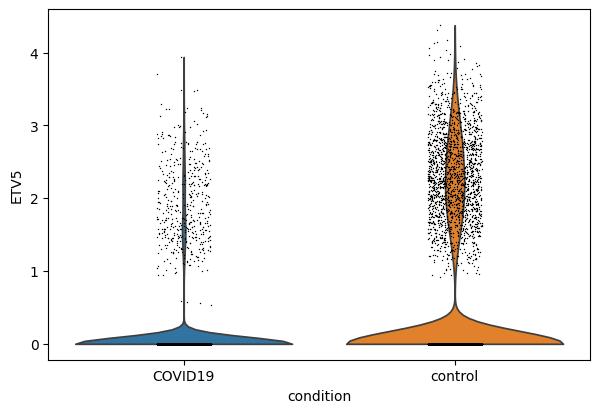

In [273]:
sc.pl.violin(subset[subset.obs.cell_type == 'AT2'], 'ETV5', groupby='condition')

In [274]:
from scipy import stats

In [282]:
temp = subset[subset.obs.cell_type == 'AT2']
i = np.where(temp.var_names == 'ETV5')[0][0]

4654